In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"

In [2]:
works_bjp = pl.read_csv("../data/works/works_bjp.csv")
works_bjp = works_bjp.filter(pl.col("year") != 2025)

In [3]:
works = pl.read_csv("../data/works/works_q1.csv")
works = works.filter(pl.col("year") != 2025)

In [4]:
year_begin = 1920
year_end = 2024
works_bjp = works_bjp.with_columns(
    age=2025 - pl.col("year")
)

bjp_cbc_per_year = (
    works_bjp
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) 

works_bjp = works_bjp.join(
    bjp_cbc_per_year,
    on="year",
    how="left"
) 

works_bjp = (
    works_bjp
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
bjp_cols_authors = [col for col in works_bjp.columns if col.startswith("author_")]

works_bjp = works_bjp.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in bjp_cols_authors]
    )

)

works_bjp = works_bjp.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works_bjp = works_bjp.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works_bjp = works_bjp.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works_bjp = works_bjp.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])


bjp_group_references_mean = (
    works_bjp.lazy()  
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works_bjp

title,year,cited_by_count,countries_distinct_count,institutions_distinct_count,citation_normalized_percentile,primary_topic,keywords,concepts,referenced_works_count,referenced_works,abstract,abstract_inverted_index,journal,author_1,author_2,author_3,author_4,author_5,institution_1,institution_2,institution_3,institution_4,institution_5,country_1,country_2,country_3,country_4,country_5,cited_by_count_2025,cited_by_count_2024,cited_by_count_2023,cited_by_count_2022,cited_by_count_2021,cited_by_count_2020,cited_by_count_2019,cited_by_count_2018,…,country_108,country_109,country_110,country_111,country_112,country_113,country_114,country_115,country_116,country_117,country_118,country_119,country_120,institution_108,institution_109,institution_110,institution_111,institution_112,institution_113,institution_114,institution_115,institution_116,institution_117,institution_118,institution_119,institution_120,institution_121,institution_122,institution_123,institution_124,institution_125,institution_126,age,mncs,authors_count,review,meta_analysis
str,i64,i64,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,i8,bool,bool
"""animal research: reporting <i>…",2010,3465,1,4,"""{'value': 0.999709, 'is_in_top…","""('Animal testing and alternati…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",6,"""['https://openalex.org/W167468…","""the nc3rs gratefully acknowled…","""{'The': [0, 222], 'NC3Rs': [1,…","""British Journal of Pharmacolog…","""https://openalex.org/A50535847…","""https://openalex.org/A50876564…","""https://openalex.org/A50047534…","""https://openalex.org/A50192845…","""https://openalex.org/A50429626…","""['National Centre for the Repl…","""['University of Bristol', 'htt…","""['University of Bristol', 'htt…","""['Imperial College London', 'h…","""['University of Oxford', 'http…","""GB""","""GB""","""GB""","""GB""","""GB""",104.0,169.0,209.0,239.0,287.0,378.0,396.0,279.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,49.882425,5,false,false
"""principles of early drug disco…",2010,2474,1,2,"""{'value': 0.763975, 'is_in_top…","""('Computational Drug Discovery…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",25,"""['https://openalex.org/W150104…","""developing a new drug from ori…","""{'Developing': [0], 'a': [1, 1…","""British Journal of Pharmacolog…","""https://openalex.org/A51099337…","""https://openalex.org/A51141727…","""https://openalex.org/A50660771…","""https://openalex.org/A51099819…",null,"""['GlaxoSmithKline (United King…","""[""King's College London"", 'htt…","""[""King's College London"", 'htt…",null,null,"""GB""","""GB""","""GB""","""GB""",null,197.0,363.0,363.0,308.0,292.0,234.0,150.0,160.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,35.615907,4,true,false
"""measuring reactive species and…",2004,2200,1,1,"""{'value': 0.990741, 'is_in_top…","""('Antioxidant Activity and Oxi…","""[]""","""[{'id': 'https://openalex.org/…",386,"""['https://openalex.org/W116935…","""free radicals and other reacti…","""{'Free': [0], 'radicals': [1],…","""British Journal of Pharmacolog…","""https://openalex.org/A50537269…","""https://openalex.org/A50691363…",null,null,null,"""['National University of Singa…","""['National University of Singa…",null,null,null,"""SG""","""SG""",null,null,null,31.0,76.0,81.0,91.0,101.0,127.0,107.0,107.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,21,36.17912,2,true,false
"""guide to receptors a

In [5]:
year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)

cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) 

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) 

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])


group_references_mean = (
    works.lazy()  
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works


title,year,cited_by_count,countries_distinct_count,institutions_distinct_count,citation_normalized_percentile,primary_topic,keywords,concepts,referenced_works_count,referenced_works,abstract,abstract_inverted_index,journal,author_1,author_2,author_3,institution_1,institution_2,institution_3,country_1,country_2,country_3,cited_by_count_2025,cited_by_count_2024,cited_by_count_2023,cited_by_count_2022,cited_by_count_2021,cited_by_count_2020,cited_by_count_2019,cited_by_count_2018,cited_by_count_2017,cited_by_count_2016,cited_by_count_2015,cited_by_count_2014,cited_by_count_2013,cited_by_count_2012,…,country_239,country_240,country_241,country_242,country_243,country_244,country_245,country_246,country_247,country_248,country_249,country_250,country_251,country_252,country_253,country_254,country_255,country_256,country_257,country_258,country_259,country_260,country_261,country_262,country_263,country_264,country_265,country_266,country_267,country_268,country_269,country_270,age,mncs,authors_count,review,meta_analysis
str,i64,i64,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,i8,bool,bool
"""ros stress in cancer cells and…",2004,1881,1,1,"""{'value': 0.816836, 'is_in_top…","""Redox biology and oxidative st…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",158,"""['https://openalex.org/W116540…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50102407…","""https://openalex.org/A50076048…","""https://openalex.org/A51006444…","""['The University of Texas MD A…","""['The University of Texas MD A…","""['The University of Texas MD A…","""US""","""US""","""US""",40.0,71.0,85.0,108.0,133.0,133.0,97.0,91.0,127.0,111.0,119.0,130.0,108.0,117.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,21,35.103559,3,false,false
"""aminoglycoside modifying enzym…",2010,1294,1,1,"""{'value': 0.995475, 'is_in_top…","""Bacteriophages and microbial i…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",336,"""['https://openalex.org/W141030…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50909767…","""https://openalex.org/A50055229…",null,"""['California State University,…","""['California State University,…",null,"""US""","""US""",null,74.0,108.0,123.0,144.0,136.0,162.0,108.0,92.0,72.0,70.0,57.0,52.0,45.0,26.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,24.857588,2,false,false
"""overcoming the blood–brain tum…",2015,898,2,6,"""{'value': 0.998282, 'is_in_top…","""Glioma Diagnosis and Treatment""","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",159,"""['https://openalex.org/W148541…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50341518…","""https://openalex.org/A50913295…","""https://openalex.org/A50395930…","""['The Netherlands Cancer Insti…","""['Amsterdam UMC Location Vrije…","""['The Netherlands Cancer Insti…","""NL""","""NL""","""NL""",80.0,87.0,97.0,110.0,116.0,119.0,91.0,80.0,59.0,43.0,15.0,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10,23.127161,6,false,false
"""targeting the pi3k/akt/mtor pa…",2008,786,1,2,"""{'value': 0.999673, 'is_in_top…","""PI3K/AKT/mTOR signaling in can…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",236,"""['https://openalex.org/W150966…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50898992…","""https://openalex.org/A50296122…","""https://openalex.org/A51080787…",

In [6]:
cols_to_stats = [
    "cited_by_count",
    "countries_distinct_count",
    "institutions_distinct_count",
    "referenced_works_count",
    "authors_count",
    "mncs"
]

agg_exprs = []

for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))

In [7]:
group_year_bjp = (
    works_bjp.group_by(
        by=pl.col("year"),
        maintain_order=True
    )
    .agg(agg_exprs)
)

group_year_q1 = (
    works.group_by(
        by=pl.col("year"),
        maintain_order=True
    )
    .agg(agg_exprs)
)

group_year_q1 = group_year_q1.sort("by", descending=False)
group_year_bjp = group_year_bjp.sort("by", descending=False)
print(group_year_q1)


shape: (116, 25)
┌──────┬────────────┬────────────┬────────────┬───┬───────────┬────────────┬───────────┬───────────┐
│ by   ┆ cited_by_c ┆ cited_by_c ┆ cited_by_c ┆ … ┆ mncs_mean ┆ mncs_media ┆ mncs_p2_5 ┆ mncs_p97_ │
│ ---  ┆ ount_mean  ┆ ount_media ┆ ount_p2_5  ┆   ┆ ---       ┆ n          ┆ ---       ┆ 5         │
│ i64  ┆ ---        ┆ n          ┆ ---        ┆   ┆ f64       ┆ ---        ┆ f64       ┆ ---       │
│      ┆ f64        ┆ ---        ┆ f64        ┆   ┆           ┆ f64        ┆           ┆ f64       │
│      ┆            ┆ f64        ┆            ┆   ┆           ┆            ┆           ┆           │
╞══════╪════════════╪════════════╪════════════╪═══╪═══════════╪════════════╪═══════════╪═══════════╡
│ 1909 ┆ 4.633333   ┆ 1.0        ┆ 0.0        ┆ … ┆ 1.0       ┆ 0.215827   ┆ 0.0       ┆ 3.23741   │
│ 1910 ┆ 3.816327   ┆ 0.0        ┆ 0.0        ┆ … ┆ 1.0       ┆ 0.0        ┆ 0.0       ┆ 15.197861 │
│ 1911 ┆ 3.02439    ┆ 0.0        ┆ 0.0        ┆ … ┆ 1.0       ┆ 0.0       

In [8]:
def gini(array):
    array = np.sort(array)
    n = len(array)
    if n == 0:
        return np.nan
    cumx = np.cumsum(array)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n if cumx[-1] > 0 else 0

def bootstrap_gini(data, n_boot=500):
    ginis = []
    n = len(data)
    if n == 0:
        return np.nan, np.nan, np.nan
    for _ in range(n_boot):
        sample = np.random.choice(data, size=n, replace=True)
        ginis.append(gini(sample))
    return np.mean(ginis), np.percentile(ginis, 2.5), np.percentile(ginis, 97.5)

In [9]:
ginis_q1, low_ginis_q1, high_ginis_q1 = [], [], []
for year in range(year_begin, year_end + 1):
    works_year = works.filter(pl.col("year") == year)
    cited = np.array(works_year["cited_by_count"].to_list())
    mean_g, low_g, high_g = bootstrap_gini(cited, n_boot=500)
    ginis_q1.append(mean_g)
    low_ginis_q1.append(low_g)
    high_ginis_q1.append(high_g)

ginis_bjp, low_ginis_bjp, high_ginis_bjp = [], [], []
for year in range(year_begin, year_end + 1):
    works_year = works_bjp.filter(pl.col("year") == year)
    cited = np.array(works_year["cited_by_count"].to_list())
    mean_g, low_g, high_g = bootstrap_gini(cited, n_boot=500)
    ginis_bjp.append(mean_g)
    low_ginis_bjp.append(low_g)
    high_ginis_bjp.append(high_g)
    
print(ginis_q1)

[np.float64(0.6911292518721468), np.float64(0.7227237393735679), np.float64(0.7865970867354413), np.float64(0.7489497543394827), np.float64(0.7474881653267921), np.float64(0.7634746215031114), np.float64(0.7409960831386864), np.float64(0.7584569875143159), np.float64(0.7586480416828196), np.float64(0.7992049136569978), np.float64(0.6558569052125875), np.float64(0.7576335761380905), np.float64(0.8508536204063891), np.float64(0.7272794553506366), np.float64(0.6969710320053137), np.float64(0.7134190454377349), np.float64(0.7519399203566439), np.float64(0.7422109162728), np.float64(0.6932732914704797), np.float64(0.7007397786294483), np.float64(0.6779599093251935), np.float64(0.8503131565115561), np.float64(0.7051550380003516), np.float64(0.7537321573809925), np.float64(0.8668499762929428), np.float64(0.755987305597979), np.float64(0.7839844377993261), np.float64(0.7143330385096899), np.float64(0.7476064228906367), np.float64(0.8743168521739075), np.float64(0.7383968664451679), np.float64(

In [10]:
group_year_count = (
    works
    .group_by("year", maintain_order=True)
    .agg(pl.len().alias("count"))
    .with_columns((pl.col("count") / pl.col("count").max()).alias("normalized_publications"))
)
bjp_group_year_count = (
    works_bjp
    .group_by("year", maintain_order=True)
    .agg(pl.len().alias("count"))
    .with_columns((pl.col("count") / pl.col("count").max()).alias("normalized_publications"))
)

group_year_count = group_year_count.sort("year",descending=False)
bjp_group_year_count = bjp_group_year_count.sort("year",descending=False)

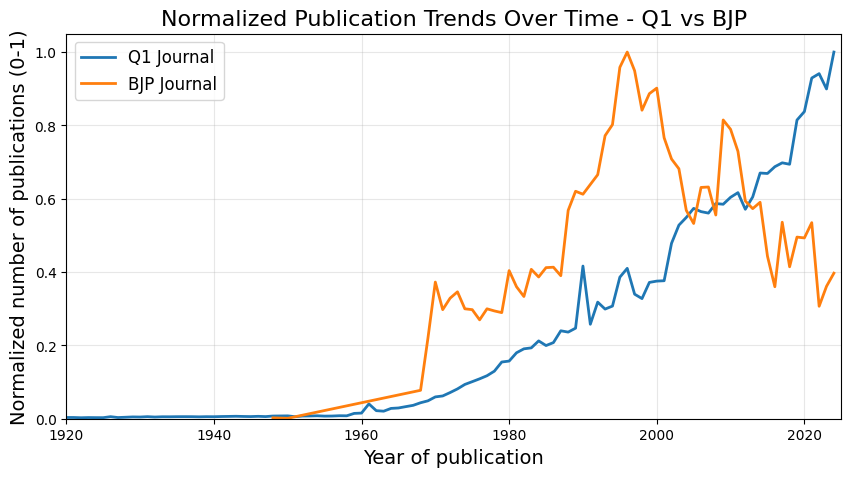

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(
    group_year_count["year"].to_numpy(),
    group_year_count["normalized_publications"].to_numpy(),
    label="Q1 Journal",
    color="tab:blue",
    linewidth=2
)
plt.plot(
    bjp_group_year_count["year"].to_numpy(),
    bjp_group_year_count["normalized_publications"].to_numpy(),
    label="BJP Journal",
    color="tab:orange",
    linewidth=2
)
plt.xlabel("Year of publication", fontsize=14)
plt.ylabel("Normalized number of publications (0-1)", fontsize=14)
plt.title("Normalized Publication Trends Over Time - Q1 vs BJP", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xlim(1920, 2025)
plt.ylim(0, 1.05)
plt.show()

In [12]:
group_year_sum = (
    works
    .group_by("year", maintain_order=True)
    .agg(
        pl.all().exclude("year").sum()
    )
)


bjp_group_year_sum = (
    works_bjp
    .group_by("year", maintain_order=True)
    .agg(
        pl.all().exclude("year").sum()
    )
)

group_year_sum = group_year_sum.sort("year",descending=False)
bjp_group_year_sum = bjp_group_year_sum.sort("year",descending=False)

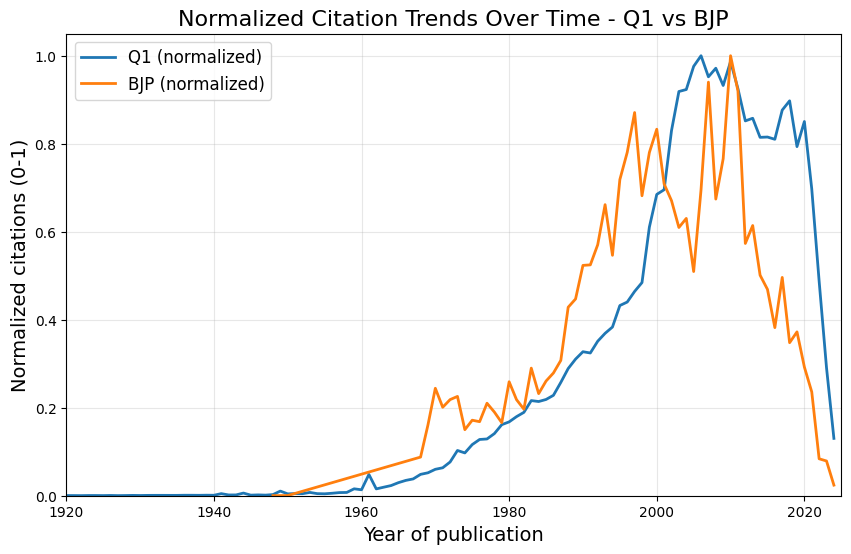

In [13]:
group_year_sum = group_year_sum.with_columns(
    (pl.col("cited_by_count") / pl.col("cited_by_count").max()).alias("normalized")
)

bjp_group_year_sum = bjp_group_year_sum.with_columns(
    (pl.col("cited_by_count") / pl.col("cited_by_count").max()).alias("normalized")
)

plt.figure(figsize=(10, 6))


plt.plot(
    group_year_sum["year"].to_numpy(),
    group_year_sum["normalized"].to_numpy(),
    label="Q1 (normalized)",
    color="tab:blue",
    linewidth=2
)

plt.plot(
    bjp_group_year_sum["year"].to_numpy(),
    bjp_group_year_sum["normalized"].to_numpy(),
    label="BJP (normalized)",
    color="tab:orange",
    linewidth=2
)

plt.xlabel("Year of publication", fontsize=14)
plt.ylabel("Normalized citations (0-1)", fontsize=14)
plt.xlim(1920, 2025)
plt.ylim(0, 1.05)
plt.legend(fontsize=12)
plt.title("Normalized Citation Trends Over Time - Q1 vs BJP", fontsize=16)
plt.grid(alpha=0.3)
plt.show()

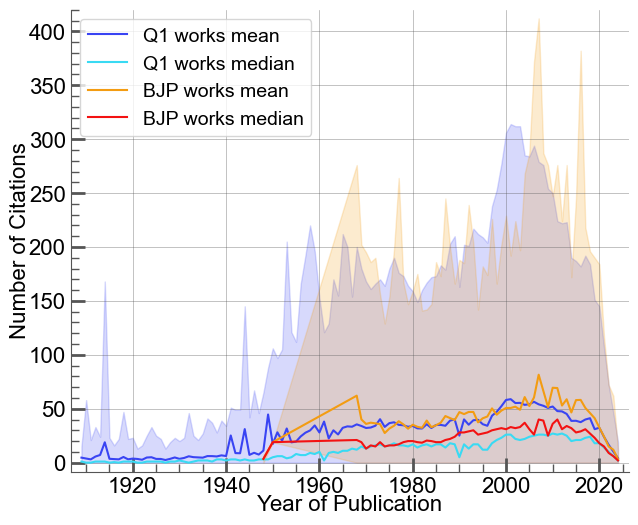

In [14]:
years_q1_ci = group_year_q1["by"].to_numpy()
mean_q1_ci = group_year_q1["cited_by_count_mean"].to_numpy()
median_q1_ci = group_year_q1["cited_by_count_median"].to_numpy()
low_q1 = group_year_q1["cited_by_count_p2_5"].to_numpy()
high_q1 = group_year_q1["cited_by_count_p97_5"].to_numpy()

years_bjp_ci = group_year_bjp["by"].to_numpy()
mean_bjp_ci = group_year_bjp["cited_by_count_mean"].to_numpy()
median_bjp_ci = group_year_bjp["cited_by_count_median"].to_numpy()
low_bjp = group_year_bjp["cited_by_count_p2_5"].to_numpy()
high_bjp = group_year_bjp["cited_by_count_p97_5"].to_numpy()

with aq.load_theme("scientific"):

    plt.figure(figsize=(7.2, 6))

    plt.plot(years_q1_ci, mean_q1_ci, color="#3944f3", label="Q1 works mean")
    plt.plot(years_q1_ci, median_q1_ci, color="#39daf3", label="Q1 works median")
    plt.fill_between(years_q1_ci, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(years_bjp_ci, mean_bjp_ci, color="#f39c12", label="BJP works mean")
    plt.plot(years_bjp_ci, median_bjp_ci, color="#f31212", label="BJP works median")
    plt.fill_between(years_bjp_ci, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Year of Publication", fontsize=16)
    plt.ylabel("Number of Citations", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.show()


<Figure size 640x480 with 0 Axes>

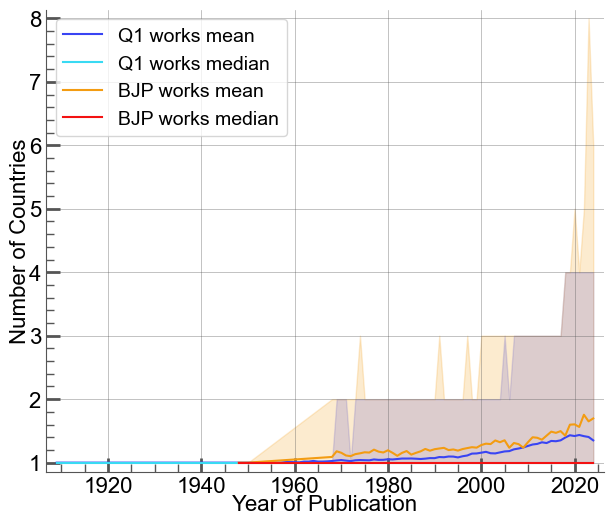

In [15]:
years_q1_ci = group_year_q1["by"].to_numpy()
mean_q1_ci = group_year_q1["countries_distinct_count_mean"].to_numpy()
median_q1_ci = group_year_q1["countries_distinct_count_median"].to_numpy()
low_q1 = group_year_q1["countries_distinct_count_p2_5"].to_numpy()
high_q1 = group_year_q1["countries_distinct_count_p97_5"].to_numpy()

years_bjp_ci = group_year_bjp["by"].to_numpy()
mean_bjp_ci = group_year_bjp["countries_distinct_count_mean"].to_numpy()
median_bjp_ci = group_year_bjp["countries_distinct_count_median"].to_numpy()
low_bjp = group_year_bjp["countries_distinct_count_p2_5"].to_numpy()
high_bjp = group_year_bjp["countries_distinct_count_p97_5"].to_numpy()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))

    plt.plot(years_q1_ci, mean_q1_ci, color="#3944f3", label="Q1 works mean")
    plt.plot(years_q1_ci, median_q1_ci, color="#39daf3", label="Q1 works median")
    plt.fill_between(years_q1_ci, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(years_bjp_ci, mean_bjp_ci, color="#f39c12", label="BJP works mean")
    plt.plot(years_bjp_ci, median_bjp_ci, color="#f31212", label="BJP works median")
    plt.fill_between(years_bjp_ci, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Year of Publication", fontsize=16)
    plt.ylabel("Number of Countries", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.show()


<Figure size 640x480 with 0 Axes>

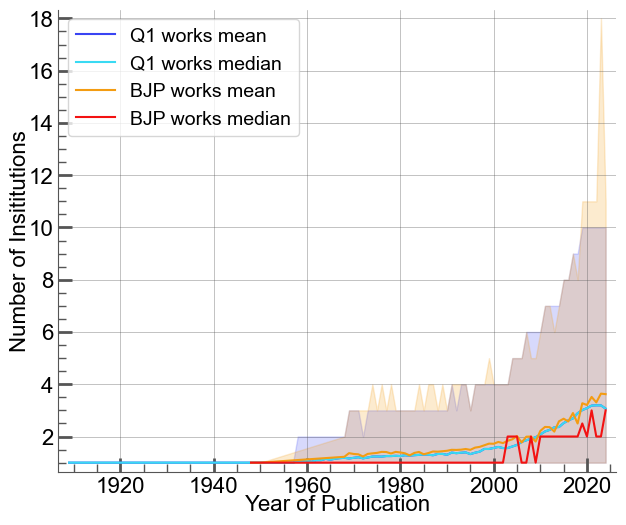

In [16]:
years_q1_ci = group_year_q1["by"].to_numpy()
mean_q1_ci = group_year_q1["institutions_distinct_count_mean"].to_numpy()
median_q1_ci = group_year_q1["institutions_distinct_count_mean"].to_numpy()
low_q1 = group_year_q1["institutions_distinct_count_p2_5"].to_numpy()
high_q1 = group_year_q1["institutions_distinct_count_p97_5"].to_numpy()

years_bjp_ci = group_year_bjp["by"].to_numpy()
mean_bjp_ci = group_year_bjp["institutions_distinct_count_mean"].to_numpy()
median_bjp_ci = group_year_bjp["institutions_distinct_count_median"].to_numpy()
low_bjp = group_year_bjp["institutions_distinct_count_p2_5"].to_numpy()
high_bjp = group_year_bjp["institutions_distinct_count_p97_5"].to_numpy()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))

    plt.plot(years_q1_ci, mean_q1_ci, color="#3944f3", label="Q1 works mean")
    plt.plot(years_q1_ci, median_q1_ci, color="#39daf3", label="Q1 works median")
    plt.fill_between(years_q1_ci, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(years_bjp_ci, mean_bjp_ci, color="#f39c12", label="BJP works mean")
    plt.plot(years_bjp_ci, median_bjp_ci, color="#f31212", label="BJP works median")
    plt.fill_between(years_bjp_ci, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Year of Publication", fontsize=16)
    plt.ylabel("Number of Insititutions", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.show()


<Figure size 640x480 with 0 Axes>

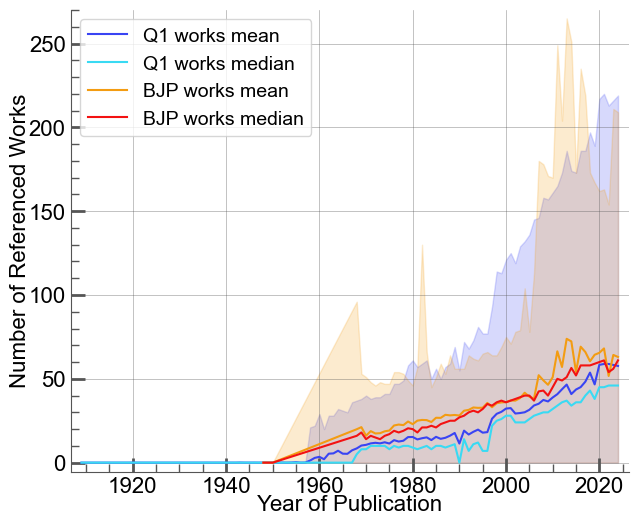

In [17]:
years_q1_ci = group_year_q1["by"].to_numpy()
mean_q1_ci = group_year_q1["referenced_works_count_mean"].to_numpy()
median_q1_ci = group_year_q1["referenced_works_count_median"].to_numpy()
low_q1 = group_year_q1["referenced_works_count_p2_5"].to_numpy()
high_q1 = group_year_q1["referenced_works_count_p97_5"].to_numpy()

years_bjp_ci = group_year_bjp["by"].to_numpy()
mean_bjp_ci = group_year_bjp["referenced_works_count_mean"].to_numpy()
median_bjp_ci = group_year_bjp["referenced_works_count_median"].to_numpy()
low_bjp = group_year_bjp["referenced_works_count_p2_5"].to_numpy()
high_bjp = group_year_bjp["referenced_works_count_p97_5"].to_numpy()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))

    plt.plot(years_q1_ci, mean_q1_ci, color="#3944f3", label="Q1 works mean")
    plt.plot(years_q1_ci, median_q1_ci, color="#39daf3", label="Q1 works median")
    plt.fill_between(years_q1_ci, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(years_bjp_ci, mean_bjp_ci, color="#f39c12", label="BJP works mean")
    plt.plot(years_bjp_ci, median_bjp_ci, color="#f31212", label="BJP works median")
    plt.fill_between(years_bjp_ci, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Year of Publication", fontsize=16)
    plt.ylabel("Number of Referenced Works", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.show()


<Figure size 640x480 with 0 Axes>

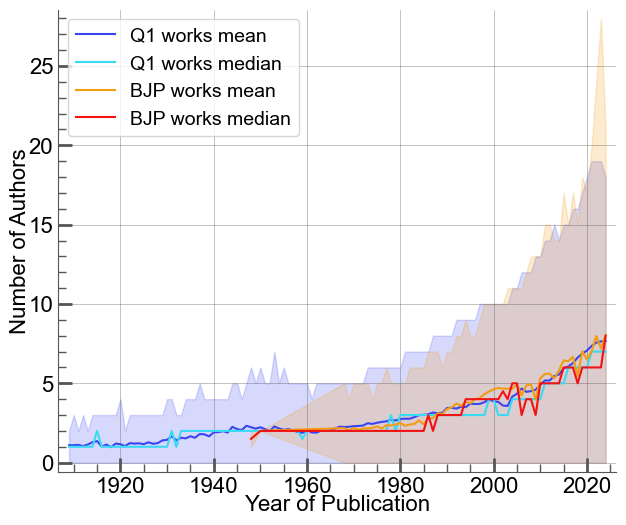

In [18]:
years_q1_ci = group_year_q1["by"].to_numpy()
mean_q1_ci = group_year_q1["authors_count_mean"].to_numpy()
median_q1_ci = group_year_q1["authors_count_median"].to_numpy()
low_q1 = group_year_q1["authors_count_p2_5"].to_numpy()
high_q1 = group_year_q1["authors_count_p97_5"].to_numpy()

years_bjp_ci = group_year_bjp["by"].to_numpy()
mean_bjp_ci = group_year_bjp["authors_count_mean"].to_numpy()
median_bjp_ci = group_year_bjp["authors_count_median"].to_numpy()
low_bjp = group_year_bjp["authors_count_p2_5"].to_numpy()
high_bjp = group_year_bjp["authors_count_p97_5"].to_numpy()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))

    plt.plot(years_q1_ci, mean_q1_ci, color="#3944f3", label="Q1 works mean")
    plt.plot(years_q1_ci, median_q1_ci, color="#39daf3", label="Q1 works median")
    plt.fill_between(years_q1_ci, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(years_bjp_ci, mean_bjp_ci, color="#f39c12", label="BJP works mean")
    plt.plot(years_bjp_ci, median_bjp_ci, color="#f31212", label="BJP works median")
    plt.fill_between(years_bjp_ci, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Year of Publication", fontsize=16)
    plt.ylabel("Number of Authors", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.show()

<Figure size 640x480 with 0 Axes>

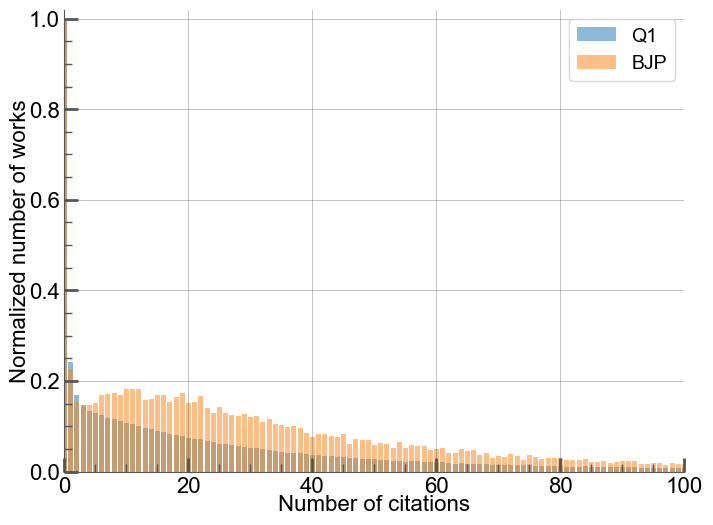

In [19]:
q1_cited = works["cited_by_count"].to_numpy()
bjp_cited = works_bjp["cited_by_count"].to_numpy()

q1_cited = q1_cited[q1_cited <= 100]
bjp_cited = bjp_cited[bjp_cited <= 100]

q1_counts = np.bincount(q1_cited)
bjp_counts = np.bincount(bjp_cited)

q1_counts_norm = q1_counts / q1_counts.max()
bjp_counts_norm = bjp_counts / bjp_counts.max()

q1_citation_range = np.arange(len(q1_counts))
bjp_citation_range = np.arange(len(bjp_counts))

color_q1 = "#1f77b4"  
color_bjp = "#ff7f0e"  

with aq.load_theme("scientific"):
    plt.figure(figsize=(8, 6))
    
    plt.bar(
        q1_citation_range,
        q1_counts_norm,
        color=color_q1,
        alpha=0.5,
        label="Q1"
    )
    
    plt.bar(
        bjp_citation_range,
        bjp_counts_norm,
        color=color_bjp,
        alpha=0.5,
        label="BJP"
    )
    
    plt.xlabel("Number of citations", fontsize=16)
    plt.ylabel("Normalized number of works", fontsize=16)
    plt.xlim(0, 100)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.show()


<Figure size 640x480 with 0 Axes>

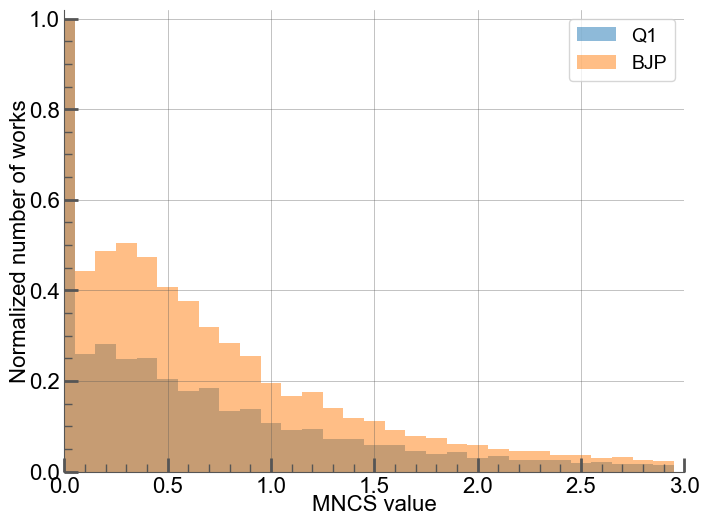

In [20]:
q1_mncs = works["mncs"].to_numpy()
q1_mncs = q1_mncs[q1_mncs <= 3]

bjp_mncs = works_bjp["mncs"].to_numpy()
bjp_mncs = bjp_mncs[bjp_mncs <= 3]

bins = np.linspace(0, 3, 31)  
q1_counts, edges = np.histogram(q1_mncs, bins=bins)
bjp_counts, _ = np.histogram(bjp_mncs, bins=bins)

q1_counts_norm = q1_counts / q1_counts.max()
bjp_counts_norm = bjp_counts / bjp_counts.max()

with aq.load_theme("scientific"):
    plt.figure(figsize=(8, 6))
    plt.bar(
        edges[:-1],
        q1_counts_norm,
        width=np.diff(edges),
        alpha=0.5,
        color="tab:blue",
        label="Q1"
    )
    plt.bar(
        edges[:-1],
        bjp_counts_norm,
        width=np.diff(edges),
        alpha=0.5,
        color="tab:orange",
        label="BJP"
    )
    plt.xlabel("MNCS value", fontsize=16)
    plt.ylabel("Normalized number of works", fontsize=16)
    plt.xlim(0, 3)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.show()


<Figure size 640x480 with 0 Axes>

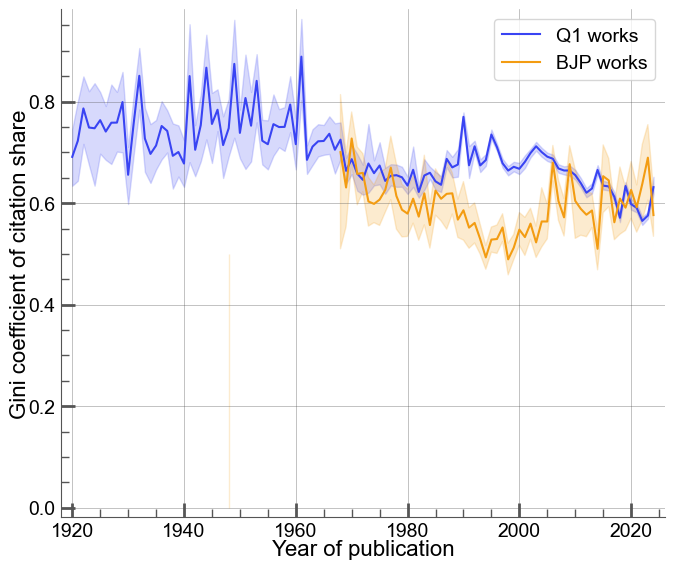

title,year,cited_by_count,countries_distinct_count,institutions_distinct_count,citation_normalized_percentile,primary_topic,keywords,concepts,referenced_works_count,referenced_works,abstract,abstract_inverted_index,journal,author_1,author_2,author_3,institution_1,institution_2,institution_3,country_1,country_2,country_3,cited_by_count_2025,cited_by_count_2024,cited_by_count_2023,cited_by_count_2022,cited_by_count_2021,cited_by_count_2020,cited_by_count_2019,cited_by_count_2018,cited_by_count_2017,cited_by_count_2016,cited_by_count_2015,cited_by_count_2014,cited_by_count_2013,cited_by_count_2012,…,country_239,country_240,country_241,country_242,country_243,country_244,country_245,country_246,country_247,country_248,country_249,country_250,country_251,country_252,country_253,country_254,country_255,country_256,country_257,country_258,country_259,country_260,country_261,country_262,country_263,country_264,country_265,country_266,country_267,country_268,country_269,country_270,age,mncs,authors_count,review,meta_analysis
str,i64,i64,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,i8,bool,bool
"""ros stress in cancer cells and…",2004,1881,1,1,"""{'value': 0.816836, 'is_in_top…","""Redox biology and oxidative st…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",158,"""['https://openalex.org/W116540…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50102407…","""https://openalex.org/A50076048…","""https://openalex.org/A51006444…","""['The University of Texas MD A…","""['The University of Texas MD A…","""['The University of Texas MD A…","""US""","""US""","""US""",40.0,71.0,85.0,108.0,133.0,133.0,97.0,91.0,127.0,111.0,119.0,130.0,108.0,117.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,21,35.103559,3,false,false
"""aminoglycoside modifying enzym…",2010,1294,1,1,"""{'value': 0.995475, 'is_in_top…","""Bacteriophages and microbial i…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",336,"""['https://openalex.org/W141030…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50909767…","""https://openalex.org/A50055229…",null,"""['California State University,…","""['California State University,…",null,"""US""","""US""",null,74.0,108.0,123.0,144.0,136.0,162.0,108.0,92.0,72.0,70.0,57.0,52.0,45.0,26.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,24.857588,2,false,false
"""overcoming the blood–brain tum…",2015,898,2,6,"""{'value': 0.998282, 'is_in_top…","""Glioma Diagnosis and Treatment""","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",159,"""['https://openalex.org/W148541…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50341518…","""https://openalex.org/A50913295…","""https://openalex.org/A50395930…","""['The Netherlands Cancer Insti…","""['Amsterdam UMC Location Vrije…","""['The Netherlands Cancer Insti…","""NL""","""NL""","""NL""",80.0,87.0,97.0,110.0,116.0,119.0,91.0,80.0,59.0,43.0,15.0,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10,23.127161,6,false,false
"""targeting the pi3k/akt/mtor pa…",2008,786,1,2,"""{'value': 0.999673, 'is_in_top…","""PI3K/AKT/mTOR signaling in can…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",236,"""['https://openalex.org/W150966…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50898992…","""https://openalex.org/A50296122…","""https://openalex.org/A51080787…",

In [21]:
x = list(range(year_begin, year_end + 1))

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.8, 6.6))

    plt.plot(x, ginis_q1, color="#3944f3", label="Q1 works")
    plt.fill_between(x, low_ginis_q1, high_ginis_q1, color="#3944f3", alpha=0.2)

    plt.plot(x, ginis_bjp, color="#f39c12", label="BJP works")
    plt.fill_between(x, low_ginis_bjp, high_ginis_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Gini coefficient of citation share", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

works

In [22]:
cols_to_stats = ["mncs", "cited_by_count"]

agg_exprs = []
for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))

group_Nauthors_q1 = (
    works.group_by("authors_count", maintain_order=True)
    .agg(agg_exprs)
    .sort("authors_count")
)

group_Nauthors_bjp = (
    works_bjp.group_by("authors_count", maintain_order=True)
    .agg(agg_exprs)
    .sort("authors_count")
)

print(group_Nauthors_q1.head())
print(group_Nauthors_bjp.head())

shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ authors_c ┆ mncs_mean ┆ mncs_medi ┆ mncs_p2_5 ┆ … ┆ cited_by_ ┆ cited_by_ ┆ cited_by_ ┆ cited_by │
│ ount      ┆ ---       ┆ an        ┆ ---       ┆   ┆ count_mea ┆ count_med ┆ count_p2_ ┆ _count_p │
│ ---       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ n         ┆ ian       ┆ 5         ┆ 97_5     │
│ i8        ┆           ┆ f64       ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 0.029746  ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.701612  ┆ 0.0       ┆ 0.0       ┆ 3.0      │
│ 1         ┆ 0.869802  ┆ 0.188493  ┆ 0.0       ┆ … ┆ 35.905374 ┆ 7.0       ┆ 0.0       ┆ 244.0    │
│ 2         ┆ 1.204872  ┆ 0.525492  ┆ 0.0       ┆ … ┆ 47.788483 ┆ 19.0      ┆

In [23]:

authors_bjp = (
    works_bjp
    .select(["title", "year", "cited_by_count", "mncs", *bjp_cols_authors])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=bjp_cols_authors,
        index=["title", "year", "index_work", "cited_by_count", "mncs"],
        variable_name="author_pos",
        value_name="author_name"
    )
    .filter(pl.col("author_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)

authors_bjp.drop("title")



year,index_work,cited_by_count,mncs,author_pos,author_name,count
i64,u32,i64,f64,str,str,i8
1948,0,7,2.0,"""author_1""","""https://openalex.org/A51142497…",1
1948,1,0,0.0,"""author_1""","""https://openalex.org/A51085631…",1
1950,2,19,1.0,"""author_1""","""https://openalex.org/A50863853…",1
1968,3,1402,22.574862,"""author_1""","""https://openalex.org/A51102298…",1
1968,4,564,9.081471,"""author_1""","""https://openalex.org/A51027517…",1
…,…,…,…,…,…,…
2021,24733,469,19.386061,"""author_100""","""https://openalex.org/A50607332…",1
2022,25427,0,0.0,"""author_100""","""https://openalex.org/A51109292…",1
2022,25441,0,0.0,"""author_100""","""https://openalex.org/A50944776…",1


In [24]:

authors = (
    works
    .select(["title", "year", "cited_by_count", "mncs", *cols_authors])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=cols_authors,
        index=["title", "year", "index_work", "cited_by_count", "mncs"],
        variable_name="author_pos",
        value_name="author_name"
    )
    .filter(pl.col("author_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)

authors.drop("title")



year,index_work,cited_by_count,mncs,author_pos,author_name,count
i64,u32,i64,f64,str,str,i8
1909,0,47,10.143885,"""author_1""","""https://openalex.org/A51102708…",1
1909,1,15,3.23741,"""author_1""","""https://openalex.org/A51116416…",1
1909,2,14,3.021583,"""author_1""","""https://openalex.org/A50125106…",1
1909,3,12,2.589928,"""author_1""","""https://openalex.org/A51121624…",1
1909,4,11,2.374101,"""author_1""","""https://openalex.org/A51136090…",1
…,…,…,…,…,…,…
2024,677238,2,0.481753,"""author_100""","""https://openalex.org/A50772361…",1
2024,677252,2,0.481753,"""author_100""","""https://openalex.org/A51140920…",1
2024,677321,1,0.240876,"""author_100""","""https://openalex.org/A50413376…",1


In [25]:
import re

cols_authors = sorted([c for c in works.columns if re.match(r"author_\d+", c)])
cols_countries = sorted([c for c in works.columns if re.match(r"country_\d+", c)])

base_cols = ["title", "year", "cited_by_count", "mncs"]
works_small = works.select(base_cols + cols_authors + cols_countries)

df_list = []

for i in range(len(cols_authors)):
    df_i = (
        works_small
        .select([
            *base_cols,
            pl.col(cols_authors[i]).alias("author"),
            pl.col(cols_countries[i]).alias("country")
        ])
        .with_columns(pos=pl.lit(i + 1))
        .filter(pl.col("author").is_not_null())
    )
    df_list.append(df_i)

authors2 = pl.concat(df_list)
authors2 = authors2.with_columns(count=pl.lit(1, dtype=pl.Int8))

authors2


title,year,cited_by_count,mncs,author,country,pos,count
str,i64,i64,f64,str,str,i32,i8
"""ros stress in cancer cells and…",2004,1881,35.103559,"""https://openalex.org/A50102407…","""US""",1,1
"""aminoglycoside modifying enzym…",2010,1294,24.857588,"""https://openalex.org/A50909767…","""US""",1,1
"""overcoming the blood–brain tum…",2015,898,23.127161,"""https://openalex.org/A50341518…","""NL""",1,1
"""targeting the pi3k/akt/mtor pa…",2008,786,14.902469,"""https://openalex.org/A50898992…","""US""",1,1
"""if not apoptosis, then what? t…",2001,722,12.263251,"""https://openalex.org/A50062088…","""US""",1,1
…,…,…,…,…,…,…,…
"""safety of covid-19 vaccines am…",2023,10,0.970459,"""https://openalex.org/A50209839…",null,100,1
"""acknowledgement to referees""",2017,0,0.0,"""https://openalex.org/A51030170…",null,100,1
"""journal of pharmacology and ex…",2013,281,6.219137,"""https://openalex.org/A50193289…",null,100,1


In [26]:


cols_authors = sorted([c for c in works_bjp.columns if re.match(r"author_\d+", c)])
cols_countries = sorted([c for c in works_bjp.columns if re.match(r"country_\d+", c)])

base_cols = ["title", "year", "cited_by_count", "mncs"]
works_small = works_bjp.select(base_cols + cols_authors + cols_countries)

df_list = []

for i in range(len(cols_authors)):
    df_i = (
        works_small
        .select([
            *base_cols,
            pl.col(cols_authors[i]).alias("author"),
            pl.col(cols_countries[i]).alias("country")
        ])
        .with_columns(pos=pl.lit(i + 1))
        .filter(pl.col("author").is_not_null())
    )
    df_list.append(df_i)

authorsg_bjp = pl.concat(df_list)
authorsg_bjp = authorsg_bjp.with_columns(count=pl.lit(1, dtype=pl.Int8))

authorsg_bjp

title,year,cited_by_count,mncs,author,country,pos,count
str,i64,i64,f64,str,str,i32,i8
"""animal research: reporting <i>…",2010,3465,49.882425,"""https://openalex.org/A50535847…","""GB""",1,1
"""principles of early drug disco…",2010,2474,35.615907,"""https://openalex.org/A51099337…","""GB""",1,1
"""measuring reactive species and…",2004,2200,36.17912,"""https://openalex.org/A50537269…","""SG""",1,1
"""guide to receptors and channel…",2011,2073,29.964208,"""https://openalex.org/A50904197…","""GB""",1,1
"""characterization of three inhi…",1990,1876,40.01629,"""https://openalex.org/A51121514…","""GB""",1,1
…,…,…,…,…,…,…,…
"""the concise guide to pharmacol…",2021,469,19.386061,"""https://openalex.org/A50662170…","""US""",100,1
"""the concise guide to pharmacol…",2023,303,25.283766,"""https://openalex.org/A50036574…","""US""",100,1
"""issue information""",2022,0,0.0,"""https://openalex.org/A50082706…","""CN""",100,1


In [27]:
top_authors = (
    authors
    .group_by(by = "author_name")
    .sum()
    .sort(by = "cited_by_count", descending=True)
    .drop(["index_work", "author_name"])
)

active_authors = (
    authors
    .group_by(by = "author_name")
    .sum()
    .sort(by = "count", descending=True)
    .drop(["index_work", "author_name"])
)

top_authors

by,title,year,cited_by_count,mncs,author_pos,count
str,str,i64,i64,f64,str,i64
"""https://openalex.org/A50406623…",null,1495708,39523,972.942793,null,748
"""https://openalex.org/A50374811…",null,824163,37048,794.874141,null,410
"""https://openalex.org/A50053578…",null,232802,35917,974.427229,null,117
"""https://openalex.org/A50807623…",null,660308,32728,745.182168,null,329
"""https://openalex.org/A50873190…",null,629484,30527,657.805362,null,313
…,…,…,…,…,…,…
"""https://openalex.org/A51041392…",null,2021,0,0.0,null,1
"""https://openalex.org/A50869961…",null,2020,0,0.0,null,1
"""https://openalex.org/A51135486…",null,1990,0,0.0,null,1


In [28]:
top_authors_bjp = (
    authors_bjp
    .group_by(by = "author_name")
    .sum()
    .sort(by = "cited_by_count", descending=True)
    .drop(["index_work", "author_name"])
)

active_authors_bjp = (
    authors_bjp
    .group_by(by = "author_name")
    .sum()
    .sort(by = "count", descending=True)
    .drop(["index_work", "author_name"])
)

top_authors_bjp

by,title,year,cited_by_count,mncs,author_pos,count
str,str,i64,i64,f64,str,i64
"""https://openalex.org/A50904197…",null,482324,21840,593.124999,null,240
"""https://openalex.org/A50053578…",null,141409,14765,333.983792,null,71
"""https://openalex.org/A50683097…",null,154809,12234,366.481811,null,77
"""https://openalex.org/A50289549…",null,98876,12065,356.596461,null,49
"""https://openalex.org/A50537650…",null,134920,11872,363.014945,null,67
…,…,…,…,…,…,…
"""https://openalex.org/A50139513…",null,2024,0,0.0,null,1
"""https://openalex.org/A50161061…",null,2024,0,0.0,null,1
"""https://openalex.org/A51139960…",null,3972,0,0.0,null,2


In [29]:
# Top 10 auteurs
top_10_authors = top_authors.head(10)

# Filtrer les vrais IDs (string)
author_ids = [aid for aid in top_10_authors["by"].to_list() if isinstance(aid, str)]

# Récupérer les infos en un seul appel API
authors_info = list(alex.Authors()[author_ids])

# Extraire aussi les institutions (batch)
inst_ids = []
id_to_info = {}
for a in authors_info:
    inst_id = None
    country = None
    if a.get("affiliations"):
        inst = a["affiliations"][0].get("institution")
        if inst:
            inst_id = inst.get("id")
            country = inst.get("country_code")
            inst_ids.append(inst_id)
    id_to_info[a["id"]] = {
        "name": a.get("display_name"),
        "institution": inst_id,
        "country": country
    }

# (Optionnel) récupérer les noms d’institutions via un batch
institutions_info = {i["id"]: i for i in alex.Institutions()[inst_ids]} if inst_ids else {}

# Ajouter les données dans le DF
top_10_authors = top_10_authors.with_columns([
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("name"), return_dtype=pl.Utf8).alias("name"),
    pl.col("by").map_elements(lambda aid: institutions_info.get(id_to_info.get(aid, {}).get("institution"), {}).get("display_name"), return_dtype=pl.Utf8).alias("institution"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("country"), return_dtype=pl.Utf8).alias("country"),
])

top_10_authors


by,title,year,cited_by_count,mncs,author_pos,count,name,institution,country
str,str,i64,i64,f64,str,i64,str,str,str
"""https://openalex.org/A50406623…",null,1495708,39523,972.942793,null,748,"""Erik De Clercq""","""Brigham Young University""","""US"""
"""https://openalex.org/A50374811…",null,824163,37048,794.874141,null,410,"""Patrice Nordmann""","""Université Paris-Sud""","""FR"""
"""https://openalex.org/A50053578…",null,232802,35917,974.427229,null,117,"""Salvador Moncada""","""University College Dublin""","""IE"""
"""https://openalex.org/A50807623…",null,660308,32728,745.182168,null,329,"""Trevor W. Robbins""","""Brighton and Sussex Medical Sc…","""GB"""
"""https://openalex.org/A50873190…",null,629484,30527,657.805362,null,313,"""Laurent Poirel""","""Université Paris-Sud""","""FR"""
"""https://openalex.org/A50271446…",null,315779,30213,681.737792,null,157,"""Rolf‐Detlef Treede""","""Goethe University Frankfurt""","""DE"""
"""https://openalex.org/A50752468…",null,439051,30031,708.192924,null,219,"""George F. Koob""","""Boston College""","""US"""
"""https://openalex.org/A50583699…",null,486304,27199,704.901406,null,244,"""Geoffrey Burnstock""","""Università Cattolica del Sacro…","""IT"""
"""https://openalex.org/A50074841…",null,450473,26159,553.90002,null,224,"""Vincenzo Di Marzo""","""University of Siena""","""IT"""


In [30]:
top_10_authors_bjp = top_authors_bjp.head(10)

author_ids = [aid for aid in top_10_authors_bjp["by"].to_list() if isinstance(aid, str)]

authors_info = list(alex.Authors()[author_ids])

inst_ids = []
id_to_info = {}
for a in authors_info:
    inst_id = None
    country = None
    if a.get("affiliations"):
        inst = a["affiliations"][0].get("institution")
        if inst:
            inst_id = inst.get("id")
            country = inst.get("country_code")
            inst_ids.append(inst_id)
    id_to_info[a["id"]] = {
        "name": a.get("display_name"),
        "institution": inst_id,
        "country": country
    }

institutions_info = {i["id"]: i for i in alex.Institutions()[inst_ids]} if inst_ids else {}

top_10_authors_bjp = top_10_authors_bjp.with_columns([
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("name"), return_dtype=pl.Utf8).alias("name"),
    pl.col("by").map_elements(lambda aid: institutions_info.get(id_to_info.get(aid, {}).get("institution"), {}).get("display_name"), return_dtype=pl.Utf8).alias("institution"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("country"), return_dtype=pl.Utf8).alias("country"),
])

top_10_authors_bjp


by,title,year,cited_by_count,mncs,author_pos,count,name,institution,country
str,str,i64,i64,f64,str,i64,str,str,str
"""https://openalex.org/A50904197…",null,482324,21840,593.124999,null,240,"""S P H Alexander""","""Centre National de la Recherch…","""FR"""
"""https://openalex.org/A50053578…",null,141409,14765,333.983792,null,71,"""Salvador Moncada""","""University College Dublin""","""IE"""
"""https://openalex.org/A50683097…",null,154809,12234,366.481811,null,77,"""John A. Peters""","""Institut polytechnique de Gren…","""FR"""
"""https://openalex.org/A50289549…",null,98876,12065,356.596461,null,49,"""Elena Faccenda""","""University of Nottingham""","""GB"""
"""https://openalex.org/A50537650…",null,134920,11872,363.014945,null,67,"""Eamonn Kelly""","""University College Dublin""","""IE"""
"""https://openalex.org/A50026335…",null,86719,10832,252.985734,null,43,"""Adam J Pawson""","""Centre National de la Recherch…","""FR"""
"""https://openalex.org/A50875219…",null,84794,10152,324.144907,null,42,"""Jamie A. Davies""","""Queen's University Belfast""","""GB"""
"""https://openalex.org/A50583699…",null,217191,9810,259.404829,null,109,"""Geoffrey Burnstock""","""Università Cattolica del Sacro…","""IT"""
"""https://openalex.org/A50449686…",null,118010,9606,165.088644,null,59,"""Roger G. Pertwee""","""Università degli Studi del Pie…","""IT"""


In [31]:
authors = authors.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("author_name") - pl.col("count")).alias("cumulative_count"),  # over() = operation group by group, like group_by+agg
    (pl.col("cited_by_count").cum_sum().over("author_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("author_name") - pl.col("mncs")).alias("cumulative_mncs")
])

authors = authors.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_authors")
)

authors

title,year,index_work,cited_by_count,mncs,author_pos,author_name,count,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_authors
str,i64,u32,i64,f64,str,str,i8,i64,i64,f64,f64
"""on the pharmacological action …",1909,0,47,10.143885,"""author_1""","""https://openalex.org/A51102708…",1,0,0,0.0,1.0
"""on the pharmacological action …",1909,0,47,10.143885,"""author_2""","""https://openalex.org/A50329477…",1,0,0,0.0,1.0
"""the antagonism of the adrenal …",1909,1,15,3.23741,"""author_1""","""https://openalex.org/A51116416…",1,0,0,0.0,1.0
"""quantitative experiments with …",1909,2,14,3.021583,"""author_1""","""https://openalex.org/A50125106…",1,0,0,0.0,1.0
"""the comparative toxicity of th…",1909,3,12,2.589928,"""author_1""","""https://openalex.org/A51121624…",1,0,0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…
"""anti-hbs positivity related to…",2024,689359,0,0.0,"""author_6""","""https://openalex.org/A50096987…",1,0,0,0.0,1.0
"""anti-hbs positivity related to…",2024,689359,0,0.0,"""author_7""","""https://openalex.org/A50455171…",1,0,0,0.0,1.0
"""antigen delivery platforms for…",2024,689360,0,0.0,"""author_1""","""https://openalex.org/A50109076…",1,2,64,1.260381,0.630191


In [32]:
authors2 = authors2.sort(["author", "year"]).with_columns([
    (pl.col("count").cum_sum().over("author") - pl.col("count")).alias("cumulative_count"),
    (pl.col("cited_by_count").cum_sum().over("author") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("author") - pl.col("mncs")).alias("cumulative_mncs")
])

authors2 = authors2.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_authors")
)

authors2


title,year,cited_by_count,mncs,author,country,pos,count,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_authors
str,i64,i64,f64,str,str,i32,i8,i64,i64,f64,f64
"""coordination between nadph oxi…",2019,17,0.54785,"""https://openalex.org/A10000051…",null,68,1,0,0,0.0,1.0
"""magnesium lithospermate b prev…",2019,30,0.966795,"""https://openalex.org/A10000051…",null,57,1,1,17,0.54785,0.54785
"""biochemical changes precede af…",2024,1,0.240876,"""https://openalex.org/A10000061…","""US""",57,1,0,0,0.0,1.0
"""a review of the immunomodulato…",2024,0,0.0,"""https://openalex.org/A10000068…",null,24,1,0,0,0.0,1.0
"""mechanism for isaxonine hepati…",1984,16,0.497951,"""https://openalex.org/A50000000…",null,46,1,0,0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…
"""acnp 55th annual meeting: post…",2016,9,0.239691,"""https://openalex.org/A99999999…",null,57,1,779,3646,101.966346,0.130894
"""acnp 55th annual meeting: post…",2016,9,0.239691,"""https://openalex.org/A99999999…",null,68,1,780,3655,102.206038,0.131033
"""acnp 55th annual meeting: post…",2016,9,0.239691,"""https://openalex.org/A99999999…",null,79,1,781,3664,102.445729,0.131173


In [33]:
authorsg_bjp = authorsg_bjp.sort(["author", "year"]).with_columns([
    (pl.col("count").cum_sum().over("author") - pl.col("count")).alias("cumulative_count"),
    (pl.col("cited_by_count").cum_sum().over("author") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("author") - pl.col("mncs")).alias("cumulative_mncs")
])

authorsg_bjp = authorsg_bjp.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_authors")
)

authorsg_bjp

title,year,cited_by_count,mncs,author,country,pos,count,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_authors
str,i64,i64,f64,str,str,i32,i8,i64,i64,f64,f64
"""binding and effects of k<sub>a…",1997,30,0.596262,"""https://openalex.org/A50000015…","""DE""",1,1,0,0,0.0,1.0
"""potent stimulation and inhibit…",2000,18,0.355347,"""https://openalex.org/A50000015…",null,13,1,1,30,0.596262,0.596262
"""synthesis and characterization…",2001,8,0.157774,"""https://openalex.org/A50000015…",null,24,1,2,48,0.95161,0.475805
"""mg<sup>2+</sup> sensitizes k<s…",2002,10,0.192653,"""https://openalex.org/A50000015…",null,46,1,3,56,1.109384,0.369795
"""binding and effect of k<sub>at…",2003,22,0.448669,"""https://openalex.org/A50000015…","""DE""",1,1,4,66,1.302036,0.325509
…,…,…,…,…,…,…,…,…,…,…,…
"""the heparan sulfate mimetic mu…",2023,5,0.417224,"""https://openalex.org/A51189413…","""CN""",1,1,0,0,0.0,1.0
"""activation of submucosal 5‐ht<…",2010,12,0.172753,"""https://openalex.org/A51191287…","""CN""",2,1,0,0,0.0,1.0
"""<scp>jak2/stat5/bcl‐xl</scp> s…",2014,54,1.159872,"""https://openalex.org/A51192063…",null,35,1,0,0,0.0,1.0


In [34]:
authors_bjp = authors_bjp.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("author_name") - pl.col("count")).alias("cumulative_count"),  # over() = operation group by group, like group_by+agg
    (pl.col("cited_by_count").cum_sum().over("author_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("author_name") - pl.col("mncs")).alias("cumulative_mncs")
])

authors_bjp = authors_bjp.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_authors")
)

authors_bjp

title,year,index_work,cited_by_count,mncs,author_pos,author_name,count,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_authors
str,i64,u32,i64,f64,str,str,i8,i64,i64,f64,f64
"""the chemo-therapeutie aetion o…",1948,0,7,2.0,"""author_1""","""https://openalex.org/A51142497…",1,0,0,0.0,1.0
"""the chemo-therapeutie aetion o…",1948,0,7,2.0,"""author_2""","""https://openalex.org/A50205694…",1,0,0,0.0,1.0
"""the constitution of pbotostilb…",1948,1,0,0.0,"""author_1""","""https://openalex.org/A51085631…",1,0,0,0.0,1.0
"""antryeide a aew trypanocidal d…",1950,2,19,1.0,"""author_1""","""https://openalex.org/A50863853…",1,0,0,0.0,1.0
"""antryeide a aew trypanocidal d…",1950,2,19,1.0,"""author_2""","""https://openalex.org/A51128128…",1,0,0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…
"""agonists of the opioid δ‐recep…",2024,26114,0,0.0,"""author_10""","""https://openalex.org/A50802596…",1,0,0,0.0,1.0
"""agonists of the opioid δ‐recep…",2024,26114,0,0.0,"""author_11""","""https://openalex.org/A51017959…",1,0,0,0.0,1.0
"""agonists of the opioid δ‐recep…",2024,26114,0,0.0,"""author_12""","""https://openalex.org/A50840481…",1,0,0,0.0,1.0


<Figure size 640x480 with 0 Axes>

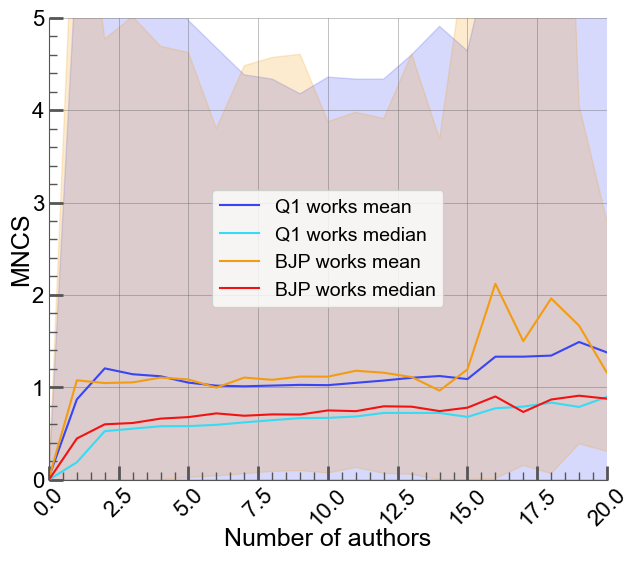

In [35]:
authors_q1 = group_Nauthors_q1["authors_count"].to_numpy()
mean_q1 = group_Nauthors_q1["mncs_mean"].to_numpy()
median_q1 = group_Nauthors_q1["mncs_median"].to_numpy()
low_q1 = group_Nauthors_q1["mncs_p2_5"].to_numpy()
high_q1 = group_Nauthors_q1["mncs_p97_5"].to_numpy()

authors2_bjp = group_Nauthors_bjp["authors_count"].to_numpy()
mean_bjp = group_Nauthors_bjp["mncs_mean"].to_numpy()
median_bjp = group_Nauthors_bjp["mncs_median"].to_numpy()
low_bjp = group_Nauthors_bjp["mncs_p2_5"].to_numpy()
high_bjp = group_Nauthors_bjp["mncs_p97_5"].to_numpy()


with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))

    plt.plot(authors_q1, mean_q1, color="#3944f3", label="Q1 works mean")
    plt.plot(authors_q1, median_q1, color="#39daf3",label="Q1 works median")
    plt.fill_between(authors_q1, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(authors2_bjp, mean_bjp, color="#f39c12", label="BJP works mean")
    plt.plot(authors2_bjp, median_bjp, color="#f31212",label="BJP works median")
    plt.fill_between(authors2_bjp, low_bjp, high_bjp, color="#f39c12", alpha=0.2)
    
    plt.ylim(0, 5)
    plt.xlim(0, 20)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Number of authors", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.legend(fontsize=14)
    plt.show()

<Figure size 640x480 with 0 Axes>

C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


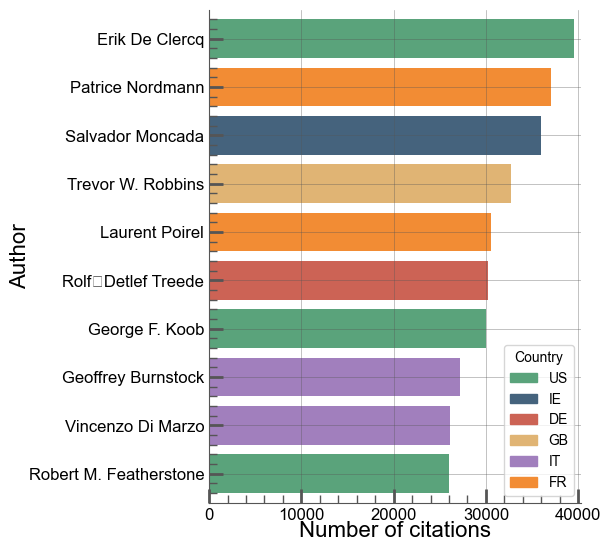

In [36]:
palette = ["#5aa37b", "#45637d", "#cc6355", "#e0b474", "#a17fbd", "#f28c34", "#6fb1fc", "#f5a6e1"]

names = top_10_authors["name"].to_list()
citations = top_10_authors["cited_by_count"].to_list()
countries = top_10_authors["country"].to_list()

unique_countries = list(set(countries))
country_colors = {country: palette[i % len(palette)] for i, country in enumerate(unique_countries)}
colors = [country_colors[c] for c in countries]

names = names[::-1]
citations = citations[::-1]
colors = colors[::-1]

with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8, 6.4))
    plt.barh(names, citations, color=colors)
    plt.xlabel("Number of citations", fontsize=16)
    plt.ylabel("Author", fontsize=16)

    handles = [plt.Rectangle((0,0),1,1, color=country_colors[c]) for c in unique_countries]
    plt.legend(handles, unique_countries, title="Country")

    plt.show()

<Figure size 640x480 with 0 Axes>

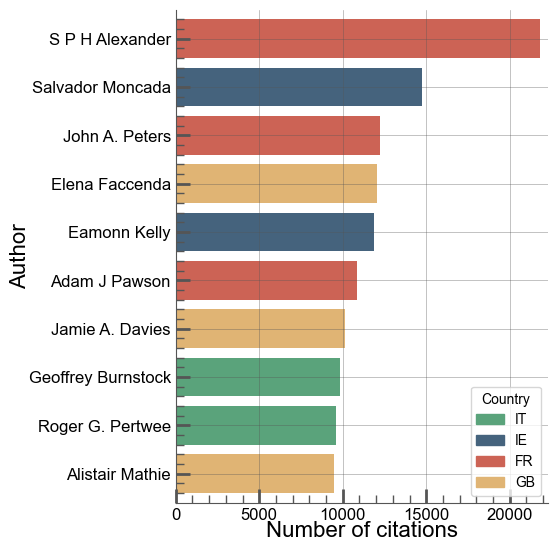

In [37]:
palette = ["#5aa37b", "#45637d", "#cc6355", "#e0b474", "#a17fbd", "#f28c34", "#6fb1fc", "#f5a6e1"]

names = top_10_authors_bjp["name"].to_list()
citations = top_10_authors_bjp["cited_by_count"].to_list()
countries = top_10_authors_bjp["country"].to_list()

unique_countries = list(set(countries))
country_colors = {country: palette[i % len(palette)] for i, country in enumerate(unique_countries)}
colors = [country_colors[c] for c in countries]

names = names[::-1]
citations = citations[::-1]
colors = colors[::-1]

with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8, 6.4))
    plt.barh(names, citations, color=colors)
    plt.xlabel("Number of citations", fontsize=16)
    plt.ylabel("Author", fontsize=16)

    handles = [plt.Rectangle((0,0),1,1, color=country_colors[c]) for c in unique_countries]
    plt.legend(handles, unique_countries, title="Country")

    plt.show()

In [38]:

top_100_authors = top_authors.head(100)

author_ids = [aid for aid in top_100_authors["by"].to_list() if isinstance(aid, str)]

def fetch_authors(ids, batch_size=50):
    results = []
    for i in range(0, len(ids), batch_size):
        batch = ids[i:i+batch_size]
        # >>> la différence clé : on passe une liste, pas une string joinée
        res = list(alex.Authors()[batch])
        results.extend(res)
    return results

authors_info = fetch_authors(author_ids)

id_to_info = {}
inst_ids = []
for a in authors_info:
    inst_id = None
    country = None
    if a.get("affiliations"):
        inst = a["affiliations"][0].get("institution")
        if inst:
            inst_id = inst.get("id")
            country = inst.get("country_code")
            inst_ids.append(inst_id)
    id_to_info[a["id"]] = {
        "name": a.get("display_name"),
        "institution": inst_id,
        "country": country
    }

top_100_authors = top_100_authors.with_columns([
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("name"), return_dtype=pl.Utf8).alias("name"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("institution"), return_dtype=pl.Utf8).alias("institution"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("country"), return_dtype=pl.Utf8).alias("country"),
])

top_100_authors

by,title,year,cited_by_count,mncs,author_pos,count,name,institution,country
str,str,i64,i64,f64,str,i64,str,str,str
"""https://openalex.org/A50406623…",null,1495708,39523,972.942793,null,748,"""Erik De Clercq""","""https://openalex.org/I10000573…","""US"""
"""https://openalex.org/A50374811…",null,824163,37048,794.874141,null,410,"""Patrice Nordmann""","""https://openalex.org/I10219740…","""FR"""
"""https://openalex.org/A50053578…",null,232802,35917,974.427229,null,117,"""Salvador Moncada""","""https://openalex.org/I10093093…","""IE"""
"""https://openalex.org/A50807623…",null,660308,32728,745.182168,null,329,"""Trevor W. Robbins""","""https://openalex.org/I10006350…","""GB"""
"""https://openalex.org/A50873190…",null,629484,30527,657.805362,null,313,"""Laurent Poirel""","""https://openalex.org/I10219740…","""FR"""
…,…,…,…,…,…,…,…,…,…
"""https://openalex.org/A50571833…",null,255751,13495,318.564569,null,127,"""Matthias Schwab""","""https://openalex.org/I10006634…","""DE"""
"""https://openalex.org/A50759606…",null,275959,13410,297.864482,null,138,"""Leslie Z. Benet""","""https://openalex.org/I11409043…","""DE"""
"""https://openalex.org/A50029696…",null,199288,13272,293.39999,null,99,"""Nora D. Volkow""","""https://openalex.org/I11197992…","""US"""


In [39]:
top_100_authors_bjp = top_authors_bjp.head(100)

author_ids = [aid for aid in top_100_authors_bjp["by"].to_list() if isinstance(aid, str)]

def fetch_authors(ids, batch_size=50):
    results = []
    for i in range(0, len(ids), batch_size):
        batch = ids[i:i+batch_size]
        # >>> la différence clé : on passe une liste, pas une string joinée
        res = list(alex.Authors()[batch])
        results.extend(res)
    return results

authors_info = fetch_authors(author_ids)

id_to_info = {}
inst_ids = []
for a in authors_info:
    inst_id = None
    country = None
    if a.get("affiliations"):
        inst = a["affiliations"][0].get("institution")
        if inst:
            inst_id = inst.get("id")
            country = inst.get("country_code")
            inst_ids.append(inst_id)
    id_to_info[a["id"]] = {
        "name": a.get("display_name"),
        "institution": inst_id,
        "country": country
    }

top_100_authors_bjp = top_100_authors_bjp.with_columns([
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("name"), return_dtype=pl.Utf8).alias("name"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("institution"), return_dtype=pl.Utf8).alias("institution"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("country"), return_dtype=pl.Utf8).alias("country"),
])

top_100_authors_bjp

by,title,year,cited_by_count,mncs,author_pos,count,name,institution,country
str,str,i64,i64,f64,str,i64,str,str,str
"""https://openalex.org/A50904197…",null,482324,21840,593.124999,null,240,"""S P H Alexander""","""https://openalex.org/I12946715…","""FR"""
"""https://openalex.org/A50053578…",null,141409,14765,333.983792,null,71,"""Salvador Moncada""","""https://openalex.org/I10093093…","""IE"""
"""https://openalex.org/A50683097…",null,154809,12234,366.481811,null,77,"""John A. Peters""","""https://openalex.org/I10678570…","""FR"""
"""https://openalex.org/A50289549…",null,98876,12065,356.596461,null,49,"""Elena Faccenda""","""https://openalex.org/I14226353…","""GB"""
"""https://openalex.org/A50537650…",null,134920,11872,363.014945,null,67,"""Eamonn Kelly""","""https://openalex.org/I10093093…","""IE"""
…,…,…,…,…,…,…,…,…,…
"""https://openalex.org/A50408693…",null,64172,2516,51.595947,null,32,"""Martin C. Michel""","""https://openalex.org/I10068134…","""US"""
"""https://openalex.org/A51099337…",null,2010,2474,35.615907,null,1,"""J. P. HUGHES""","""https://openalex.org/I28000307…","""US"""
"""https://openalex.org/A50660771…",null,2010,2474,35.615907,null,1,"""S. Barret Kalindjian""","""https://openalex.org/I12619302…","""GB"""


<Figure size 640x480 with 0 Axes>

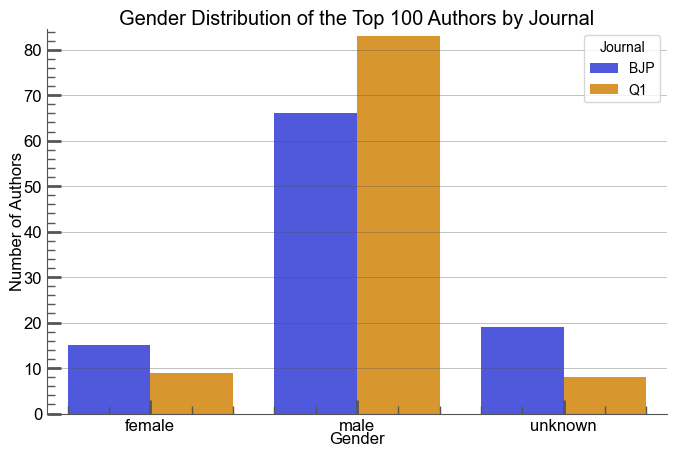

In [40]:
import gender_guesser.detector as gender

d = gender.Detector()

def normalize_gender(g):
    if g in ["male","mostly_male"]:
        return "male"
    elif g in ["female","mostly_female"]:
        return "female"
    else:
        return "unknown"

def extract_first_names(names):
    first_names = []
    for n in names:
        if isinstance(n, str):
            first_author = n.split("&")[0].strip()
            first_name = first_author.split()[0].strip()
            first_names.append(first_name)
        elif isinstance(n, list) and len(n) > 0:
            first_author = n[0].strip()
            first_name = first_author.split()[0].strip()
            first_names.append(first_name)
        else:
            first_names.append(None)
    return first_names

def build_gender_df(names, journal_label):
    first_names = extract_first_names(names)
    gender_map_list = [(name, normalize_gender(d.get_gender(name))) for name in first_names if name]
    df_gender = pd.DataFrame(gender_map_list, columns=["first_name", "gender"])
    df_gender["journal"] = journal_label
    return df_gender

df_gender_q1 = build_gender_df(top_100_authors["name"], "Q1")
df_gender_bjp = build_gender_df(top_100_authors_bjp["name"], "BJP")

df_gender_all = pd.concat([df_gender_q1, df_gender_bjp], ignore_index=True)

gender_counts = df_gender_all.groupby(["journal", "gender"]).size().reset_index(name="count")

plt.figure(figsize=(8,5))
sns.barplot(data=gender_counts, x="gender", y="count", hue="journal", palette=["#3944f3", "#f39c12"])
plt.title("Gender Distribution of the Top 100 Authors by Journal")
plt.xlabel("Gender")
plt.ylabel("Number of Authors")
plt.legend(title="Journal")
plt.show()

In [41]:
active_100_authors = active_authors.head(100)

author_ids = [aid for aid in active_100_authors["by"].to_list() if isinstance(aid, str)]

def fetch_authors(ids, batch_size=50):
    results = []
    for i in range(0, len(ids), batch_size):
        batch = ids[i:i+batch_size]
        # >>> la différence clé : on passe une liste, pas une string joinée
        res = list(alex.Authors()[batch])
        results.extend(res)
    return results

authors_info = fetch_authors(author_ids)

id_to_info = {}
inst_ids = []
for a in authors_info:
    inst_id = None
    country = None
    if a.get("affiliations"):
        inst = a["affiliations"][0].get("institution")
        if inst:
            inst_id = inst.get("id")
            country = inst.get("country_code")
            inst_ids.append(inst_id)
    id_to_info[a["id"]] = {
        "name": a.get("display_name"),
        "institution": inst_id,
        "country": country
    }

active_100_authors = active_100_authors.with_columns([
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("name"), return_dtype=pl.Utf8).alias("name"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("institution"), return_dtype=pl.Utf8).alias("institution"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("country"), return_dtype=pl.Utf8).alias("country"),
])

active_100_authors

by,title,year,cited_by_count,mncs,author_pos,count,name,institution,country
str,str,i64,i64,f64,str,i64,str,str,str
"""https://openalex.org/A99999999…",null,1558668,3691,103.164803,null,784,null,null,null
"""https://openalex.org/A50406623…",null,1495708,39523,972.942793,null,748,"""Erik De Clercq""","""https://openalex.org/I10000573…","""US"""
"""https://openalex.org/A50201253…",null,1402441,1270,40.985707,null,695,"""Sarah Crunkhorn""","""https://openalex.org/I12806409…","""US"""
"""https://openalex.org/A50188815…",null,1219279,10374,429.945174,null,604,"""Asher Mullard""","""https://openalex.org/I12806409…","""US"""
"""https://openalex.org/A50458774…",null,955705,7732,180.894305,null,476,"""Siegfried Kasper""","""https://openalex.org/I11286295…","""IT"""
…,…,…,…,…,…,…,…,…,…
"""https://openalex.org/A50381744…",null,326985,1117,58.243083,null,162,"""Katie Kingwell""","""https://openalex.org/I12806409…","""US"""
"""https://openalex.org/A50730463…",null,325263,12384,278.829047,null,162,"""Roger L. Nation""","""https://openalex.org/I12405569…","""DK"""
"""https://openalex.org/A50035316…",null,325750,6761,154.716017,null,162,"""Joseph Zohar""","""https://openalex.org/I10414671…","""IL"""


In [42]:
active_100_authors_bjp = active_authors_bjp.head(100)

author_ids = [aid for aid in active_100_authors_bjp["by"].to_list() if isinstance(aid, str)]

def fetch_authors(ids, batch_size=50):
    results = []
    for i in range(0, len(ids), batch_size):
        batch = ids[i:i+batch_size]
        # >>> la différence clé : on passe une liste, pas une string joinée
        res = list(alex.Authors()[batch])
        results.extend(res)
    return results

authors_info = fetch_authors(author_ids)

id_to_info = {}
inst_ids = []
for a in authors_info:
    inst_id = None
    country = None
    if a.get("affiliations"):
        inst = a["affiliations"][0].get("institution")
        if inst:
            inst_id = inst.get("id")
            country = inst.get("country_code")
            inst_ids.append(inst_id)
    id_to_info[a["id"]] = {
        "name": a.get("display_name"),
        "institution": inst_id,
        "country": country
    }

active_100_authors_bjp = active_100_authors_bjp.with_columns([
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("name"), return_dtype=pl.Utf8).alias("name"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("institution"), return_dtype=pl.Utf8).alias("institution"),
    pl.col("by").map_elements(lambda aid: id_to_info.get(aid, {}).get("country"), return_dtype=pl.Utf8).alias("country"),
])

active_100_authors_bjp

by,title,year,cited_by_count,mncs,author_pos,count,name,institution,country
str,str,i64,i64,f64,str,i64,str,str,str
"""https://openalex.org/A50904197…",null,482324,21840,593.124999,null,240,"""S P H Alexander""","""https://openalex.org/I12946715…","""FR"""
"""https://openalex.org/A50583699…",null,217191,9810,259.404829,null,109,"""Geoffrey Burnstock""","""https://openalex.org/I10332073…","""IT"""
"""https://openalex.org/A50593191…",null,203325,7046,137.163483,null,102,"""J.C. McGrath""","""https://openalex.org/I12304494…","""ES"""
"""https://openalex.org/A51120349…",null,193509,3484,75.906379,null,97,"""Sheila M. Gardiner""","""https://openalex.org/I13100532…","""GB"""
"""https://openalex.org/A50593829…",null,176910,7640,191.483111,null,89,"""John R. Vane""","""https://openalex.org/I10000573…","""US"""
…,…,…,…,…,…,…,…,…,…
"""https://openalex.org/A50408693…",null,64172,2516,51.595947,null,32,"""Martin C. Michel""","""https://openalex.org/I10068134…","""US"""
"""https://openalex.org/A50628763…",null,63927,1365,29.067566,null,32,"""Ikunobu Muramatsu""","""https://openalex.org/I10091056""","""JP"""
"""https://openalex.org/A51100146…",null,63716,1278,31.745104,null,32,"""Roy G. Goldie""","""https://openalex.org/I14531194…","""US"""


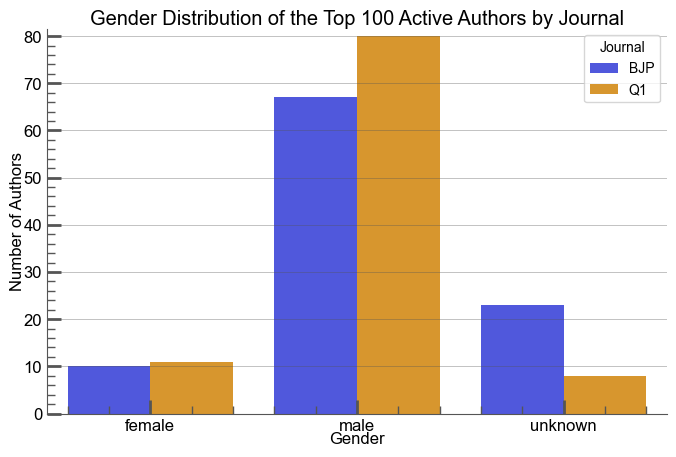

In [43]:
df_gender_q1 = build_gender_df(active_100_authors["name"], "Q1")
df_gender_bjp = build_gender_df(active_100_authors_bjp["name"], "BJP")

df_gender_all = pd.concat([df_gender_q1, df_gender_bjp], ignore_index=True)

gender_counts = df_gender_all.groupby(["journal", "gender"]).size().reset_index(name="count")

plt.figure(figsize=(8,5))
sns.barplot(data=gender_counts, x="gender", y="count", hue="journal", palette=["#3944f3", "#f39c12"])
plt.title("Gender Distribution of the Top 100 Active Authors by Journal")
plt.xlabel("Gender")
plt.ylabel("Number of Authors")
plt.legend(title="Journal")
plt.show()

In [44]:
countries_col = [f"country_{i}" for i in range(1, 193)]

countries = (
    works
    .select(["year", "cited_by_count", "mncs", *countries_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)

countries

year,index_work,cited_by_count,mncs,country_pos,country_name,count
i64,u32,i64,f64,str,str,i8
1948,4737,9,0.803571,"""country_1""","""AT""",1
1948,4740,1,0.089286,"""country_1""","""CH""",1
1955,6245,30,1.534133,"""country_1""","""DE""",1
1958,6927,373,12.49231,"""country_1""","""US""",1
1958,6928,177,5.927986,"""country_1""","""US""",1
…,…,…,…,…,…,…
2017,506649,18,0.449923,"""country_190""","""GB""",1
2015,466011,0,0.0,"""country_191""","""BE""",1
2017,506649,18,0.449923,"""country_191""","""CA""",1


In [45]:
countries_col = [f"country_{i}" for i in range(1, 121)]

countries_bjp= (
    works_bjp
    .select(["year", "cited_by_count", "mncs", *countries_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)

countries_bjp

year,index_work,cited_by_count,mncs,country_pos,country_name,count
i64,u32,i64,f64,str,str,i8
1968,3,1402,22.574862,"""country_1""","""US""",1
1968,5,276,4.444124,"""country_1""","""SE""",1
1968,6,134,2.157654,"""country_1""","""CH""",1
1968,7,131,2.109349,"""country_1""","""AU""",1
1968,8,130,2.093247,"""country_1""","""GB""",1
…,…,…,…,…,…,…
2022,25441,0,0.0,"""country_117""","""JP""",1
2022,25454,0,0.0,"""country_117""","""JP""",1
2022,25427,0,0.0,"""country_118""","""NO""",1


In [46]:
group_countriesyears = (
    countries
    .drop("country_pos")
    .group_by(["country_name", "year"], maintain_order=True).sum()
    .sort("year")
)

cols_to_stats = [
    "cited_by_count",
    "age",
    "count",
    "mncs"
]

agg_exprs = []

for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))

In [47]:
group_countries = (
    countries
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(
        count=pl.col("count").sum(),
         *agg_exprs
         )
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

group_countries_bjp = (
    countries_bjp
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(count=pl.col("count").sum(),
         *agg_exprs
         )  
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

group_countries = group_countries.sort("count", descending=True)
group_countires_bjp = group_countries_bjp.sort("count", descending=True)

print(group_countries_bjp)

shape: (119, 14)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────┐
│ country_na ┆ cited_by_c ┆ cited_by_c ┆ cited_by_ ┆ … ┆ mncs_mean ┆ mncs_p2_5 ┆ mncs_p97_ ┆ count │
│ me         ┆ ount_mean  ┆ ount_p2_5  ┆ count_p97 ┆   ┆ ---       ┆ ---       ┆ 5         ┆ ---   │
│ ---        ┆ ---        ┆ ---        ┆ _5        ┆   ┆ f64       ┆ f64       ┆ ---       ┆ i64   │
│ str        ┆ f64        ┆ f64        ┆ ---       ┆   ┆           ┆           ┆ f64       ┆       │
│            ┆            ┆            ┆ f64       ┆   ┆           ┆           ┆           ┆       │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ GB         ┆ 67.067028  ┆ 1.0        ┆ 344.0     ┆ … ┆ 1.547024  ┆ 0.024194  ┆ 9.088005  ┆ 20872 │
│ US         ┆ 60.210328  ┆ 0.0        ┆ 280.0     ┆ … ┆ 1.372875  ┆ 0.0       ┆ 6.475215  ┆ 15918 │
│ JP         ┆ 39.885128  ┆ 3.0        ┆ 158.0     ┆ … ┆ 0.854911  ┆ 0.070

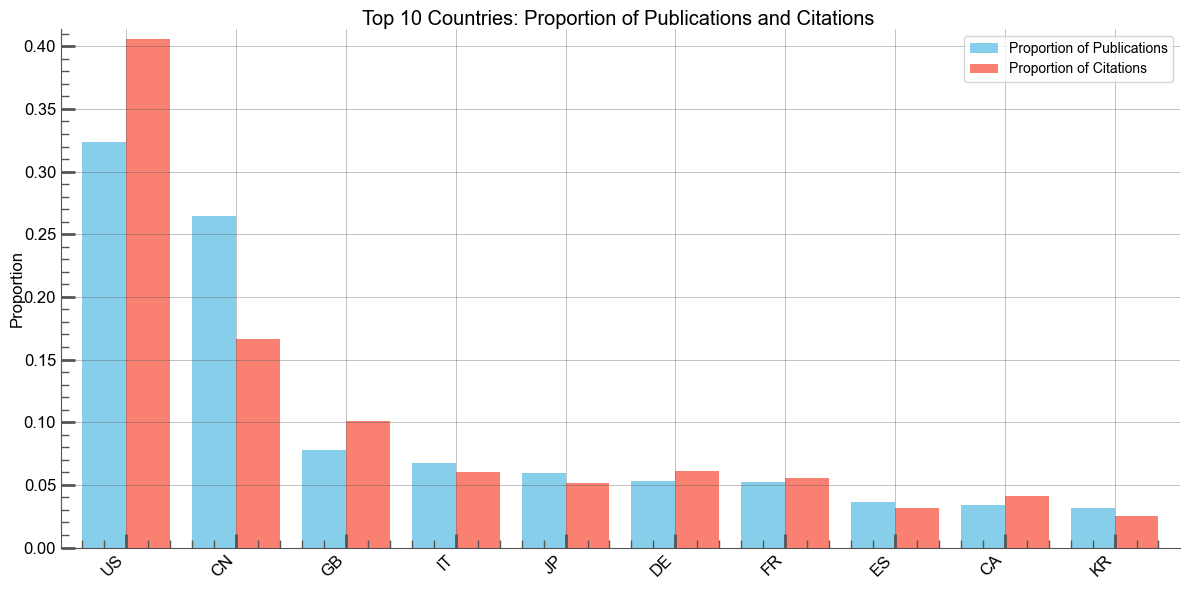

In [48]:
top_countries = (
    group_countries.sort("count", descending=True)
                   .head(10)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_top_countries = group_countries.filter(pl.col("country_name").is_in(top_countries)).to_pandas()
df_top_countries_years = group_countriesyears.filter(
    pl.col("country_name").is_in(top_countries)
).to_pandas()

df_top_countries["prop_publications"] = df_top_countries["count"] / df_top_countries["count"].sum()
df_top_countries["prop_citations"] = df_top_countries["cited_by_count_mean"] * df_top_countries["count"]
df_top_countries["prop_citations"] /= df_top_countries["prop_citations"].sum()

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.4
countries = df_top_countries["country_name"]
x = range(len(countries))

ax.bar(x, df_top_countries["prop_publications"], width=width, label="Proportion of Publications", color="skyblue")

ax.bar([i + width for i in x], df_top_countries["prop_citations"], width=width, label="Proportion of Citations", color="salmon")

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 10 Countries: Proportion of Publications and Citations ")
ax.legend()
plt.tight_layout()
plt.show()

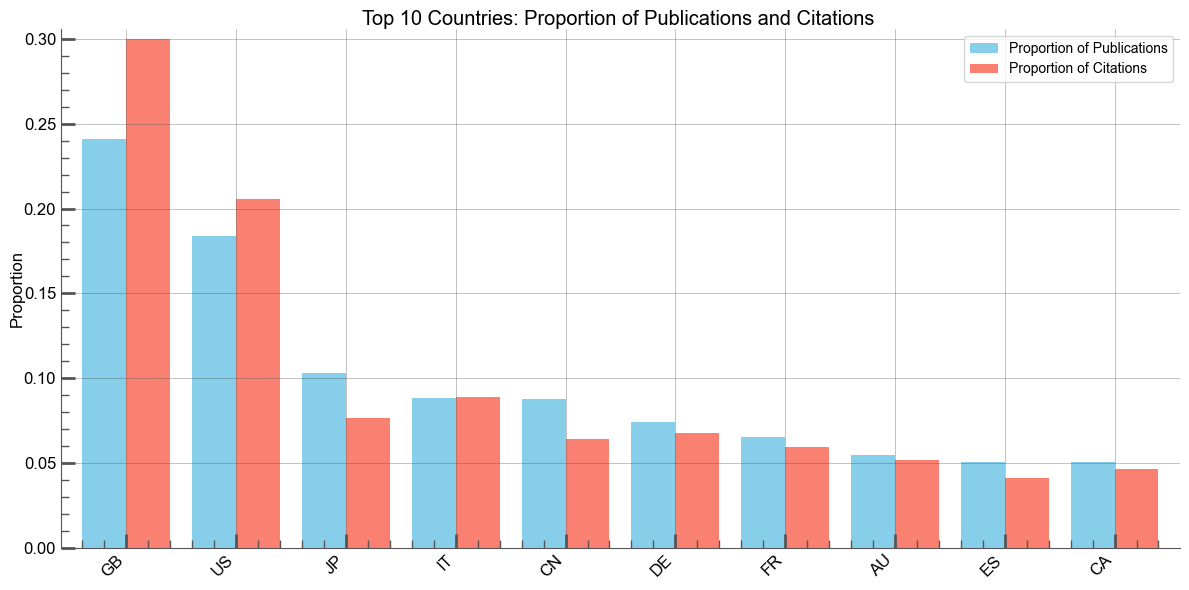

In [49]:
top_countries_bjp = (
    group_countries_bjp.sort("count", descending=True)
                   .head(10)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_top_countries = group_countries_bjp.filter(pl.col("country_name").is_in(top_countries_bjp)).to_pandas()
df_top_countries_years = group_countriesyears.filter(
    pl.col("country_name").is_in(top_countries)
).to_pandas()

df_top_countries["prop_publications"] = df_top_countries["count"] / df_top_countries["count"].sum()
df_top_countries["prop_citations"] = df_top_countries["cited_by_count_mean"] * df_top_countries["count"]
df_top_countries["prop_citations"] /= df_top_countries["prop_citations"].sum()

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.4
countries = df_top_countries["country_name"]
x = range(len(countries))

ax.bar(x, df_top_countries["prop_publications"], width=width, label="Proportion of Publications", color="skyblue")

ax.bar([i + width for i in x], df_top_countries["prop_citations"], width=width, label="Proportion of Citations", color="salmon")

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 10 Countries: Proportion of Publications and Citations ")
ax.legend()
plt.tight_layout()
plt.show()

In [50]:
import itertools
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

pairs_counter = {}
author_collab_totals = {}

for index_work, group in authors.group_by("index_work"):
    author_list = list(group["author_name"])
    if len(author_list) >= 2:
        for pair in itertools.combinations(sorted(author_list), 2):
            pairs_counter[pair] = pairs_counter.get(pair, 0) + 1
            author_collab_totals[pair[0]] = author_collab_totals.get(pair[0], 0) + 1
            author_collab_totals[pair[1]] = author_collab_totals.get(pair[1], 0) + 1

top_authors = sorted(author_collab_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_authors = [a for a, _ in top_authors]

author_ids = [aid for aid in top_authors if isinstance(aid, str)]

def fetch_authors(ids, batch_size=50):
    results = []
    for i in range(0, len(ids), batch_size):
        batch = ids[i:i+batch_size]
        res = list(alex.Authors()[batch])
        results.extend(res)
    return results

authors_info = fetch_authors(author_ids)

id_to_info = {}
for a in authors_info:
    inst_id, country = None, None
    if a.get("affiliations"):
        inst = a["affiliations"][0].get("institution")
        if inst:
            inst_id = inst.get("id")
            country = inst.get("country_code")
    id_to_info[a["id"]] = {
        "name": a.get("display_name"),
        "institution": inst_id,
        "country": country
    }

top_25_authors_df = pl.DataFrame({"author_id": author_ids})
top_25_authors_df = top_25_authors_df.with_columns([
    pl.col("author_id").map_elements(lambda aid: id_to_info.get(aid, {}).get("name"), return_dtype=pl.Utf8).alias("name"),
    pl.col("author_id").map_elements(lambda aid: id_to_info.get(aid, {}).get("institution"), return_dtype=pl.Utf8).alias("institution"),
    pl.col("author_id").map_elements(lambda aid: id_to_info.get(aid, {}).get("country"), return_dtype=pl.Utf8).alias("country"),
])




C:\Users\noahr\AppData\Local\Temp\ipykernel_7328\1713778227.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")
C:\Users\noahr\AppData\Local\Temp\ipykernel_7328\1713778227.py:37: UserWarning: Glyph 128105 (\N{WOMAN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\noahr\AppData\Local\Temp\ipykernel_7328\1713778227.py:37: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128105 (\N{WOMAN}) missing from font(s) Arial.
  fi

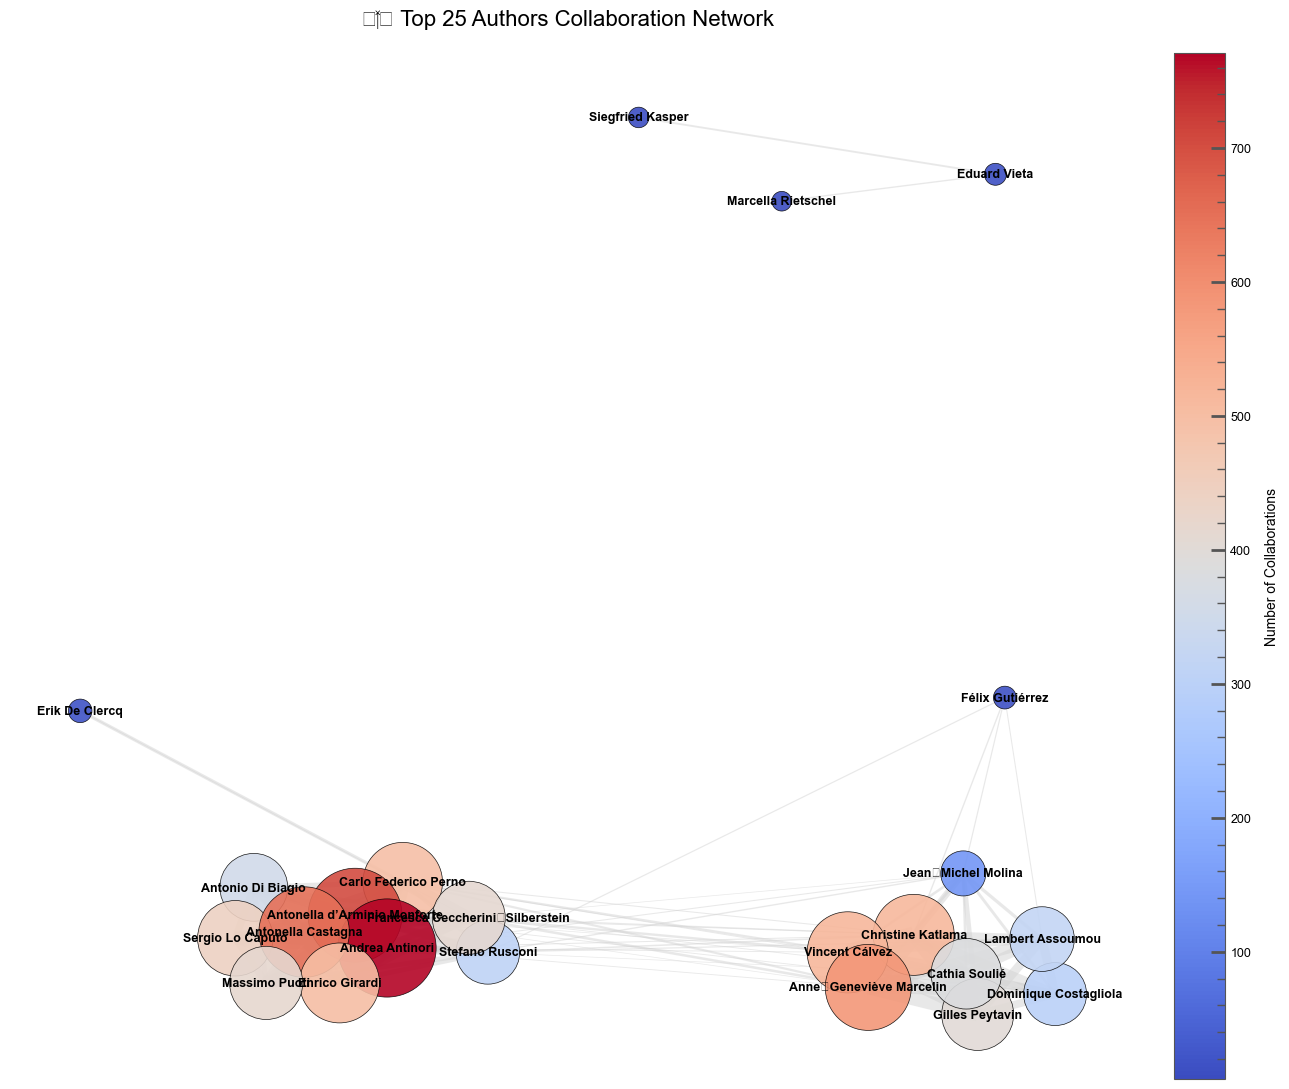

In [51]:
top_25_ids = set(top_25_authors_df["author_id"].to_list())
G = nx.Graph()

for (a1, a2), count in pairs_counter.items():
    if a1 in top_25_ids and a2 in top_25_ids and a1 != a2:
        G.add_edge(a1, a2, weight=count)

if len(G.nodes) > 0 and len(G.edges) > 0:
    node_vals = np.array([deg for node, deg in G.degree(weight='weight')])
    node_sizes = 200 + (node_vals - node_vals.min()) / (node_vals.max() - node_vals.min() + 1e-9) * (5000 - 200)

    edge_vals = np.array([G[u][v]['weight'] for u, v in G.edges()])
    edge_weights = 0.5 + (edge_vals - edge_vals.min()) / (edge_vals.max() - edge_vals.min() + 1e-9) * (20 - 0.5)

    cmap = cm.get_cmap("coolwarm")
    norm = mcolors.Normalize(vmin=node_vals.min(), vmax=node_vals.max())
    colors = cmap(norm(node_vals))

    pos = nx.spring_layout(G, k=1.1, weight='weight', seed=42)

    fig, ax = plt.subplots(figsize=(13, 11))
    nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, edge_color='lightgray', alpha=0.5)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, node_color=colors, alpha=0.9, edgecolors='black', linewidths=0.5)

    # Créer les labels uniquement pour les nœuds présents dans le graphe
    labels = {node: id_to_info.get(node, {}).get("name", node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, ax=ax, font_size=9, font_weight='bold')

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Number of Collaborations", fontsize=10, labelpad=10)

    ax.set_title("👩‍🔬 Top 25 Authors Collaboration Network", fontsize=16, pad=20)
    ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Aucun nœud ou arête à afficher pour ces top auteurs.")



In [52]:
import itertools
from tqdm import tqdm
import pandas as pd
import polars as pl
"""
pairs_counter = {}
author_collab_totals = {}

print("🔍 Étape 1/3 : Comptage des collaborations...")

# Remplacer les None par 'Unknown' pour éviter les erreurs
authors2 = authors2.with_columns([
    pl.col("author").fill_null("Unknown"),
    pl.col("country").fill_null("Unknown")
])

# Conversion Polars → pandas pour le groupby
authors_pd = authors2.to_pandas()
grouped = list(authors_pd.groupby("title"))

for title, group in tqdm(grouped, desc="Calcul collaborations", total=len(grouped)):
    author_list = list(group["author"])
    country_list = list(group["country"])
    if len(author_list) >= 2:
        # Trier par auteur pour éviter doublons
        for (a1, c1), (a2, c2) in itertools.combinations(sorted(zip(author_list, country_list)), 2):
            key = tuple(sorted([a1, a2]))
            pairs_counter[key] = pairs_counter.get(key, 0) + 1
            author_collab_totals[a1] = author_collab_totals.get(a1, 0) + 1
            author_collab_totals[a2] = author_collab_totals.get(a2, 0) + 1

print(f"✅ {len(pairs_counter):,} paires de collaborations enregistrées.")
print(f"✅ {len(author_collab_totals):,} auteurs uniques détectés.\n")

# --- Étape 2 : création des nœuds et arêtes ---

print("🧩 Étape 2/3 : Construction des nœuds et arêtes...")

# Table des auteurs -> pays (premier pays trouvé)
author_country_map = (
    authors_pd.groupby("author")["country"]
    .first()
    .to_dict()
)

edges = pd.DataFrame([
    {
        "source": a1,
        "target": a2,
        "weight": count,
        "source_country": author_country_map.get(a1, "Unknown"),
        "target_country": author_country_map.get(a2, "Unknown"),
    }
    for (a1, a2), count in pairs_counter.items()
])

nodes = pd.DataFrame({
    "id": list(author_collab_totals.keys()),
    "label": list(author_collab_totals.keys()),
    "collaborations": list(author_collab_totals.values()),
    "country": [author_country_map.get(a, "Unknown") for a in author_collab_totals.keys()]
})

print(f"✅ {len(nodes):,} nœuds et {len(edges):,} arêtes prêts à être exportés.\n")

# --- Étape 3 : export pour Gephi ---
print("💾 Étape 3/3 : Export des fichiers CSV pour Gephi...")

nodes.to_csv("nodes_q1.csv", index=False)
edges.to_csv("edges_q1.csv", index=False)

print("\n✅ Export terminé avec succès !") """


'\npairs_counter = {}\nauthor_collab_totals = {}\n\nprint("🔍 Étape 1/3 : Comptage des collaborations...")\n\n# Remplacer les None par \'Unknown\' pour éviter les erreurs\nauthors2 = authors2.with_columns([\n    pl.col("author").fill_null("Unknown"),\n    pl.col("country").fill_null("Unknown")\n])\n\n# Conversion Polars → pandas pour le groupby\nauthors_pd = authors2.to_pandas()\ngrouped = list(authors_pd.groupby("title"))\n\nfor title, group in tqdm(grouped, desc="Calcul collaborations", total=len(grouped)):\n    author_list = list(group["author"])\n    country_list = list(group["country"])\n    if len(author_list) >= 2:\n        # Trier par auteur pour éviter doublons\n        for (a1, c1), (a2, c2) in itertools.combinations(sorted(zip(author_list, country_list)), 2):\n            key = tuple(sorted([a1, a2]))\n            pairs_counter[key] = pairs_counter.get(key, 0) + 1\n            author_collab_totals[a1] = author_collab_totals.get(a1, 0) + 1\n            author_collab_totals[a2]

In [53]:
import itertools
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os

# --- 🔧 Préparation des données ---
authors2 = authors2.with_columns([
    pl.col("author").fill_null("Unknown"),
    pl.col("country").fill_null("Unknown")
])

authors_pd = authors2.to_pandas()
authors_pd["decade"] = (authors_pd["year"] // 10) * 10
authors_pd = authors_pd[authors_pd["decade"] >= 1910]

decades = sorted(authors_pd["decade"].unique())
print(f"🧮 {len(decades)} décennies à analyser : {decades}")

# --- 📂 Fichier de sauvegarde ---
SAVE_PATH = "results_network_metrics.csv"

# Si un fichier existe déjà, on le charge pour reprendre
if os.path.exists(SAVE_PATH):
    df_results = pd.read_csv(SAVE_PATH)
    done_decades = set(df_results["decade"])
    print(f"♻️ Reprise depuis le fichier existant : {len(done_decades)} décennies déjà calculées.")
else:
    df_results = pd.DataFrame()
    done_decades = set()

results = []

# --- ⚙️ Analyse par décennie ---
for decade in decades:
    if decade in done_decades:
        print(f"⏭️ Décennie {decade} déjà traitée, on saute.")
        continue

    df_dec = authors_pd[authors_pd["decade"] == decade]
    print(f"\n🔹 Analyse de la décennie {decade} ({len(df_dec)} enregistrements)")
    t0 = time.time()

    # tqdm interne
    titles = df_dec["title"].unique()
    pairs_counter = {}

    for title in tqdm(titles, desc=f"→ Décennie {decade}", leave=False):
        group = df_dec[df_dec["title"] == title]
        authors = list(group["author"])
        if len(authors) >= 2:
            for (a1, a2) in itertools.combinations(sorted(authors), 2):
                key = (a1, a2)
                pairs_counter[key] = pairs_counter.get(key, 0) + 1

    if not pairs_counter:
        print(f"⚠️ Aucune collaboration trouvée pour {decade}")
        continue

    # --- Création du graphe ---
    edges = pd.DataFrame([{"source": a1, "target": a2, "weight": w}
                          for (a1, a2), w in pairs_counter.items()])
    G = nx.from_pandas_edgelist(edges, "source", "target", edge_attr="weight")

    total_nodes = G.number_of_nodes()
    if total_nodes == 0:
        continue

    # --- Calcul des métriques ---
    largest = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest)

    size_lcc = len(largest)
    ratio_lcc = size_lcc / total_nodes
    avg_degree = sum(dict(G.degree()).values()) / total_nodes
    density = nx.density(G)
    avg_clustering = nx.average_clustering(G)
    num_components = nx.number_connected_components(G)

    avg_path_length = None
    diameter = None
    if size_lcc < 3000:
        try:
            avg_path_length = nx.average_shortest_path_length(G_lcc)
        except Exception:
            pass
        try:
            diameter = nx.diameter(G_lcc)
        except Exception:
            pass

    result = {
        "decade": decade,
        "total_nodes": total_nodes,
        "size_lcc": size_lcc,
        "ratio_lcc": ratio_lcc,
        "avg_degree": avg_degree,
        "density": density,
        "avg_clustering": avg_clustering,
        "num_components": num_components,
        "avg_path_length": avg_path_length,
        "diameter": diameter,
        "time_sec": round(time.time() - t0, 1)
    }

    results.append(result)
    df_results = pd.concat([df_results, pd.DataFrame([result])], ignore_index=True)

    # 💾 Sauvegarde automatique après chaque décennie
    df_results.to_csv(SAVE_PATH, index=False)
    print(f"✅ {decade} traité ({result['time_sec']}s) — {total_nodes} nœuds, LCC={size_lcc}, ratio={ratio_lcc:.2%}")

# --- 📊 Résumé final ---
print("\n📊 Résumé des métriques calculées :")
print(df_results.sort_values("decade"))



🧮 12 décennies à analyser : [np.int64(1910), np.int64(1920), np.int64(1930), np.int64(1940), np.int64(1950), np.int64(1960), np.int64(1970), np.int64(1980), np.int64(1990), np.int64(2000), np.int64(2010), np.int64(2020)]
♻️ Reprise depuis le fichier existant : 10 décennies déjà calculées.
⏭️ Décennie 1910 déjà traitée, on saute.
⏭️ Décennie 1920 déjà traitée, on saute.
⏭️ Décennie 1930 déjà traitée, on saute.
⏭️ Décennie 1940 déjà traitée, on saute.
⏭️ Décennie 1950 déjà traitée, on saute.
⏭️ Décennie 1960 déjà traitée, on saute.
⏭️ Décennie 1970 déjà traitée, on saute.
⏭️ Décennie 1980 déjà traitée, on saute.
⏭️ Décennie 1990 déjà traitée, on saute.
⏭️ Décennie 2000 déjà traitée, on saute.

🔹 Analyse de la décennie 2010 (1141393 enregistrements)


C:\Users\noahr\AppData\Local\Temp\ipykernel_7328\3196617236.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([result])], ignore_index=True)


✅ 2010 traité (30381.5s) — 554805 nœuds, LCC=502685, ratio=90.61%

🔹 Analyse de la décennie 2020 (1010836 enregistrements)


✅ 2020 traité (33443.0s) — 567825 nœuds, LCC=511453, ratio=90.07%

📊 Résumé des métriques calculées :
    decade  total_nodes  size_lcc  ratio_lcc  avg_degree   density  \
0     1910          279        45   0.161290    2.222222  0.007994   
1     1920          508        34   0.066929    2.019685  0.003984   
2     1930         1079        94   0.087118    2.337349  0.002168   
3     1940         1795       407   0.226741    3.208914  0.001789   
4     1950         2413       963   0.399088    3.501036  0.001452   
5     1960        10015      3488   0.348278    5.125711  0.000512   
6     1970        34920     20023   0.573396    6.181844  0.000177   
7     1980        85478     60222   0.704532    6.412668  0.000075   
8     1990       173888    136577   0.785431    7.762008  0.000045   
9     2000       309287    260435   0.842050    9.951915  0.000032   
10    2010       554805    502685   0.906057   14.788053  0.000027   
11    2020       567825    511453   0.900723   15.898930  

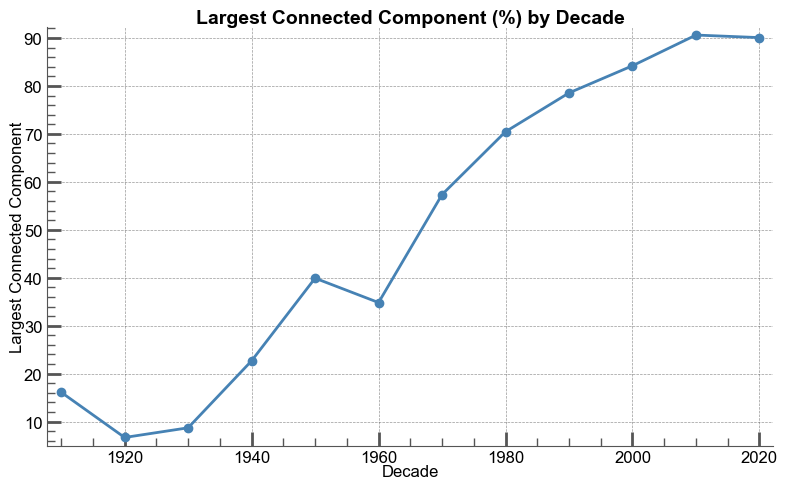

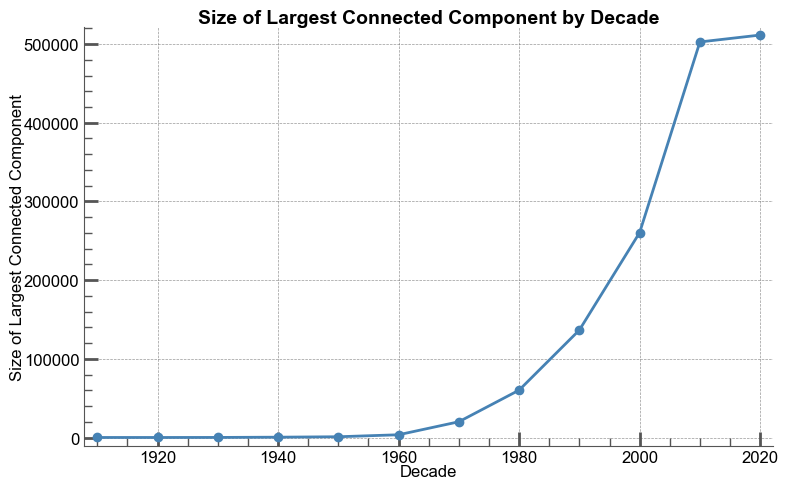

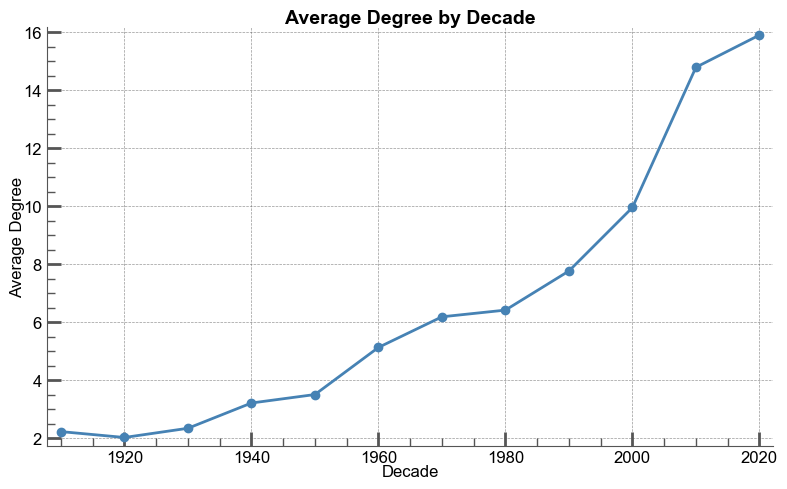

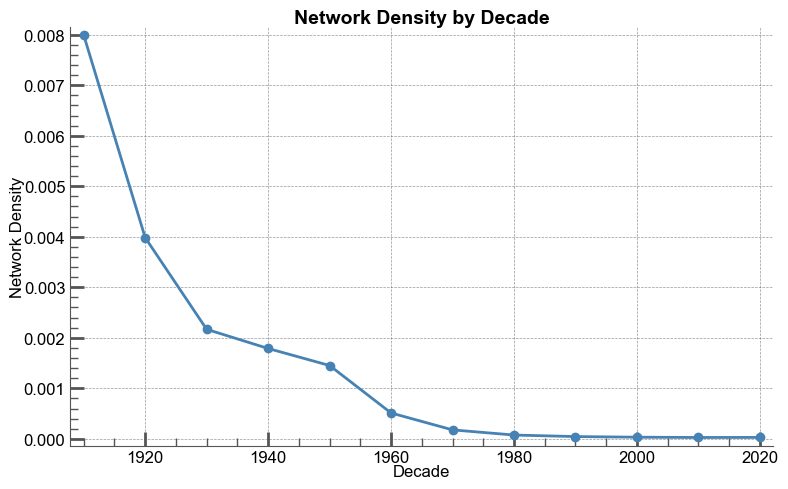

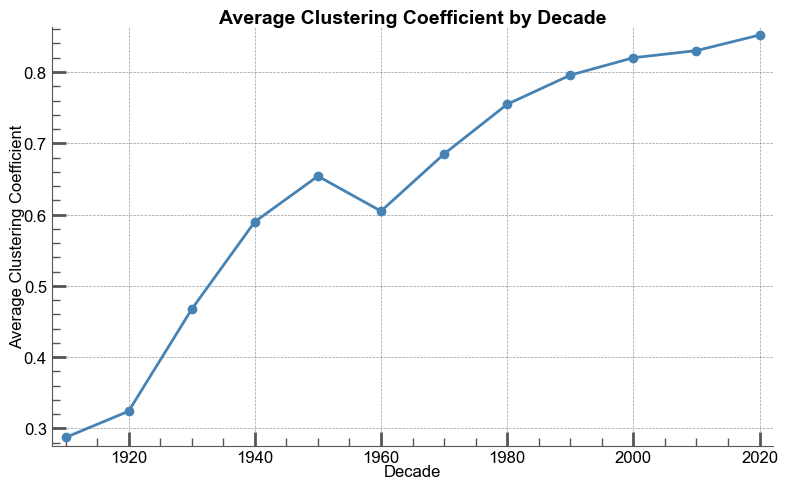

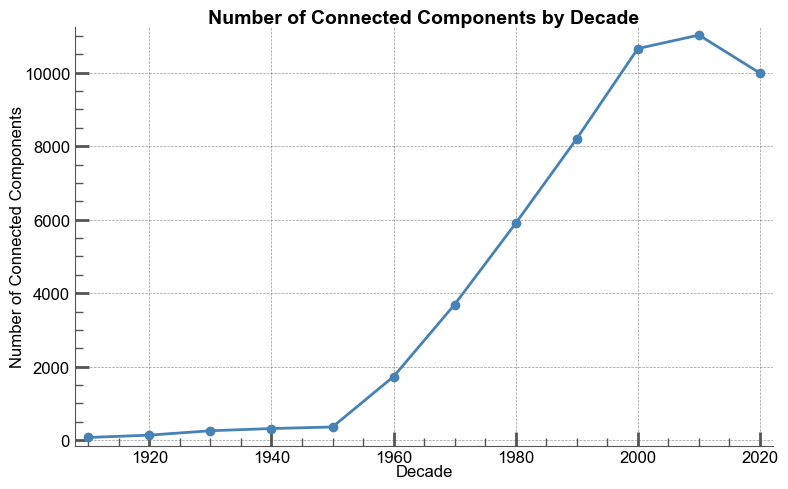

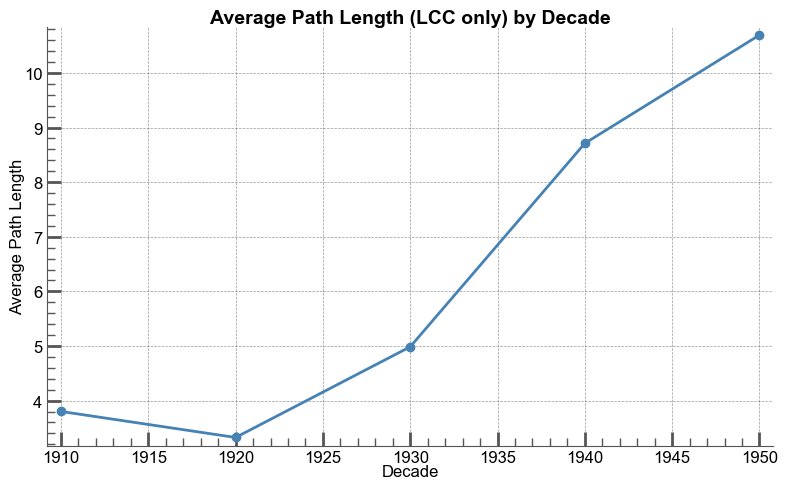

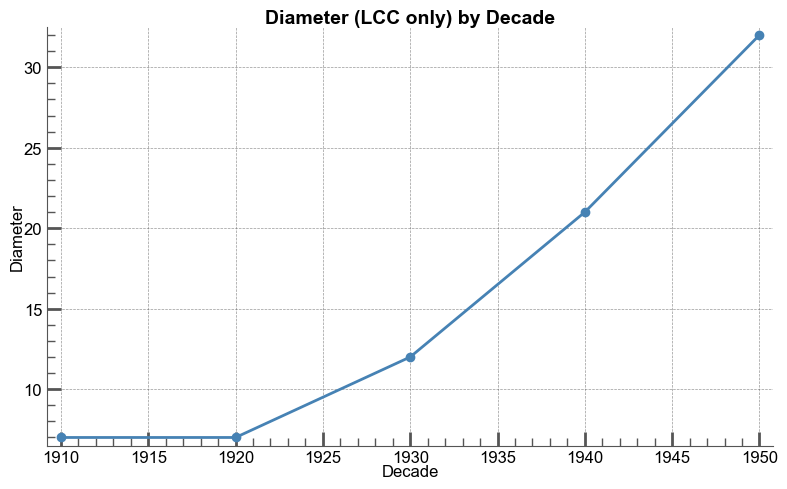

In [54]:
import matplotlib.pyplot as plt

metrics = [
    ("ratio_lcc", "Largest Connected Component (%)", lambda x: x * 100),
    ("size_lcc", "Size of Largest Connected Component", None),
    ("avg_degree", "Average Degree", None),
    ("density", "Network Density", None),
    ("avg_clustering", "Average Clustering Coefficient", None),
    ("num_components", "Number of Connected Components", None),
    ("avg_path_length", "Average Path Length (LCC only)", None),
    ("diameter", "Diameter (LCC only)", None),
]

# Generate one figure per metric
for col, title, transform in metrics:
    if col not in df_results.columns:
        continue  # skip missing metrics
    
    plt.figure(figsize=(8, 5))
    y = transform(df_results[col]) if transform else df_results[col]
    plt.plot(df_results["decade"], y, marker="o", linewidth=2, color="steelblue")
    
    plt.title(f"{title} by Decade", fontsize=14, fontweight="bold")
    plt.xlabel("Decade")
    plt.ylabel(title.split("(")[0].strip())
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


Analyse par décennie: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


   decade  size_lcc  ratio_lcc
0    1940         2   1.000000
1    1950         2   1.000000
2    1960         8   0.020779
3    1970       825   0.248195
4    1980      2078   0.368570
5    1990      8575   0.576316
6    2000      8265   0.463779
7    2010      8788   0.412621
8    2020      3107   0.286069


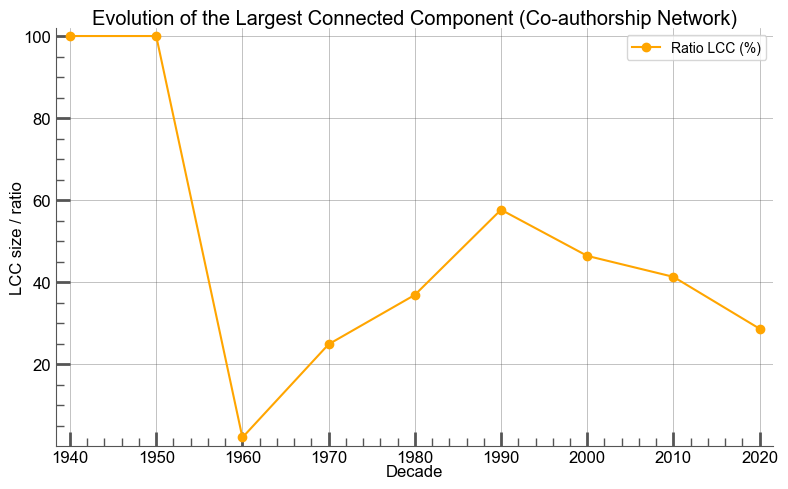

In [55]:
authorsg_bjp = authorsg_bjp.with_columns([
    pl.col("author").fill_null("Unknown"),
    pl.col("country").fill_null("Unknown")
])

authors_pd = authorsg_bjp.to_pandas()
authors_pd["decade"] = (authors_pd["year"] // 10) * 10
authors_pd = authors_pd[authors_pd["decade"] >= 1910]  

results = []

for decade, df_dec in tqdm(authors_pd.groupby("decade"), desc="Analyse par décennie"):
    pairs_counter = {}

    for title, group in df_dec.groupby("title"):
        author_list = list(group["author"])
        if len(author_list) >= 2:
            for (a1, a2) in itertools.combinations(sorted(author_list), 2):
                key = tuple(sorted([a1, a2]))
                pairs_counter[key] = pairs_counter.get(key, 0) + 1

    if not pairs_counter:
        continue

    edges = pd.DataFrame([{"source": a1, "target": a2, "weight": count}
                          for (a1, a2), count in pairs_counter.items()])
    G = nx.from_pandas_edgelist(edges, "source", "target", edge_attr="weight")

    total_nodes = G.number_of_nodes()
    if total_nodes == 0:
        continue

    largest = max(nx.connected_components(G), key=len)
    size_lcc = len(largest)
    ratio_lcc = size_lcc / total_nodes

    results.append({
        "decade": decade,
        "size_lcc": size_lcc,
        "ratio_lcc": ratio_lcc
    })

df_results = pd.DataFrame(results).sort_values("decade")
print(df_results)

plt.figure(figsize=(8,5))
plt.plot(df_results["decade"], df_results["ratio_lcc"] * 100, marker="o", color="orange", label="Ratio LCC (%)")
#plt.bar(df_results["decade"], df_results["size_lcc"], width=8, alpha=0.3, label="Size LCC")
plt.title("Evolution of the Largest Connected Component (Co-authorship Network)")
plt.xlabel("Decade")
plt.ylabel("LCC size / ratio")
plt.legend()
plt.tight_layout()
plt.show()


In [64]:
import itertools
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os

# --- 🔧 Préparation des données ---
authorsg_bjp = authorsg_bjp.with_columns([
    pl.col("author").fill_null("Unknown"),
    pl.col("country").fill_null("Unknown")
])

authors_pd = authorsg_bjp.to_pandas()
authors_pd["decade"] = (authors_pd["year"] // 10) * 10
authors_pd = authors_pd[authors_pd["decade"] >= 1910]

decades = sorted(authors_pd["decade"].unique())
print(f"🧮 {len(decades)} décennies à analyser : {decades}")

# --- 📂 Fichier de sauvegarde ---
SAVE_PATH = "results_network_metrics_bjp.csv"

# Si un fichier existe déjà, on le charge pour reprendre
if os.path.exists(SAVE_PATH):
    df_results = pd.read_csv(SAVE_PATH)
    done_decades = set(df_results["decade"])
    print(f"♻️ Reprise depuis le fichier existant : {len(done_decades)} décennies déjà calculées.")
else:
    df_results = pd.DataFrame()
    done_decades = set()

results = []

# --- ⚙️ Analyse par décennie ---
for decade in decades:
    if decade in done_decades:
        print(f"⏭️ Décennie {decade} déjà traitée, on saute.")
        continue

    df_dec = authors_pd[authors_pd["decade"] == decade]
    print(f"\n🔹 Analyse de la décennie {decade} ({len(df_dec)} enregistrements)")
    t0 = time.time()

    # tqdm interne
    titles = df_dec["title"].unique()
    pairs_counter = {}

    for title in tqdm(titles, desc=f"→ Décennie {decade}", leave=False):
        group = df_dec[df_dec["title"] == title]
        authors = list(group["author"])
        if len(authors) >= 2:
            for (a1, a2) in itertools.combinations(sorted(authors), 2):
                key = (a1, a2)
                pairs_counter[key] = pairs_counter.get(key, 0) + 1

    if not pairs_counter:
        print(f"⚠️ Aucune collaboration trouvée pour {decade}")
        continue

    # --- Création du graphe ---
    edges = pd.DataFrame([{"source": a1, "target": a2, "weight": w}
                          for (a1, a2), w in pairs_counter.items()])
    G = nx.from_pandas_edgelist(edges, "source", "target", edge_attr="weight")

    total_nodes = G.number_of_nodes()
    if total_nodes == 0:
        continue

    # --- Calcul des métriques ---
    largest = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest)

    size_lcc = len(largest)
    ratio_lcc = size_lcc / total_nodes
    avg_degree = sum(dict(G.degree()).values()) / total_nodes
    density = nx.density(G)
    avg_clustering = nx.average_clustering(G)
    num_components = nx.number_connected_components(G)

    avg_path_length = None
    diameter = None
    if size_lcc < 3000:
        try:
            avg_path_length = nx.average_shortest_path_length(G_lcc)
        except Exception:
            pass
        try:
            diameter = nx.diameter(G_lcc)
        except Exception:
            pass

    result = {
        "decade": decade,
        "total_nodes": total_nodes,
        "size_lcc": size_lcc,
        "ratio_lcc": ratio_lcc,
        "avg_degree": avg_degree,
        "density": density,
        "avg_clustering": avg_clustering,
        "num_components": num_components,
        "avg_path_length": avg_path_length,
        "diameter": diameter,
        "time_sec": round(time.time() - t0, 1)
    }

    results.append(result)
    df_results = pd.concat([df_results, pd.DataFrame([result])], ignore_index=True)

    # 💾 Sauvegarde automatique après chaque décennie
    df_results.to_csv(SAVE_PATH, index=False)
    print(f"✅ {decade} traité ({result['time_sec']}s) — {total_nodes} nœuds, LCC={size_lcc}, ratio={ratio_lcc:.2%}")

# --- 📊 Résumé final ---
print("\n📊 Résumé des métriques calculées :")
print(df_results.sort_values("decade"))



🧮 9 décennies à analyser : [np.int64(1940), np.int64(1950), np.int64(1960), np.int64(1970), np.int64(1980), np.int64(1990), np.int64(2000), np.int64(2010), np.int64(2020)]

🔹 Analyse de la décennie 1940 (3 enregistrements)


✅ 1940 traité (0.0s) — 2 nœuds, LCC=2, ratio=100.00%

🔹 Analyse de la décennie 1950 (2 enregistrements)


✅ 1950 traité (0.0s) — 2 nœuds, LCC=2, ratio=100.00%

🔹 Analyse de la décennie 1960 (530 enregistrements)


✅ 1960 traité (0.2s) — 385 nœuds, LCC=8, ratio=2.08%

🔹 Analyse de la décennie 1970 (5957 enregistrements)


✅ 1970 traité (11.8s) — 3324 nœuds, LCC=825, ratio=24.82%

🔹 Analyse de la décennie 1980 (10014 enregistrements)


✅ 1980 traité (75.1s) — 5638 nœuds, LCC=2078, ratio=36.86%

🔹 Analyse de la décennie 1990 (27355 enregistrements)


C:\Users\noahr\AppData\Local\Temp\ipykernel_7328\121212237.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([result])], ignore_index=True)


✅ 1990 traité (18.0s) — 14879 nœuds, LCC=8575, ratio=57.63%

🔹 Analyse de la décennie 2000 (27026 enregistrements)


✅ 2000 traité (13.7s) — 17821 nœuds, LCC=8265, ratio=46.38%

🔹 Analyse de la décennie 2010 (28118 enregistrements)


✅ 2010 traité (11.4s) — 21298 nœuds, LCC=8788, ratio=41.26%

🔹 Analyse de la décennie 2020 (13126 enregistrements)


✅ 2020 traité (3.1s) — 10861 nœuds, LCC=3107, ratio=28.61%

📊 Résumé des métriques calculées :
   decade  total_nodes  size_lcc  ratio_lcc  avg_degree   density  \
0    1940            2         2   1.000000    1.000000  1.000000   
1    1950            2         2   1.000000    1.000000  1.000000   
2    1960          385         8   0.020779    2.051948  0.005344   
3    1970         3324       825   0.248195    4.268351  0.001284   
4    1980         5638      2078   0.368570    7.481376  0.001327   
5    1990        14879      8575   0.576316    6.591841  0.000443   
6    2000        17821      8265   0.463779    7.473430  0.000419   
7    2010        21298      8788   0.412621   10.000939  0.000470   
8    2020        10861      3107   0.286069   15.701501  0.001446   

   avg_clustering  num_components  avg_path_length diameter  time_sec  
0        0.000000               1         1.000000        1       0.0  
1        0.000000               1         1.000000        1       0.0 

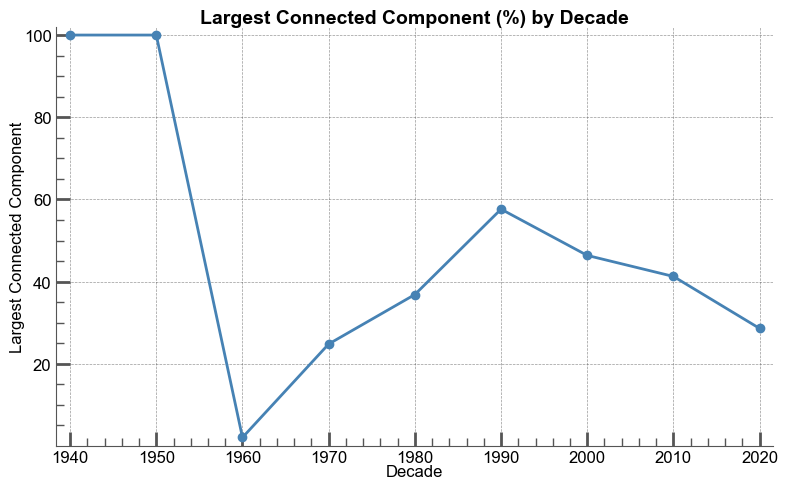

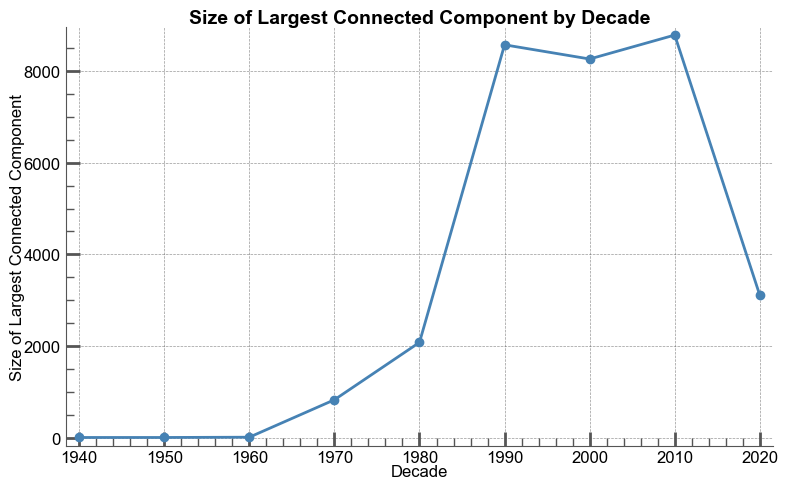

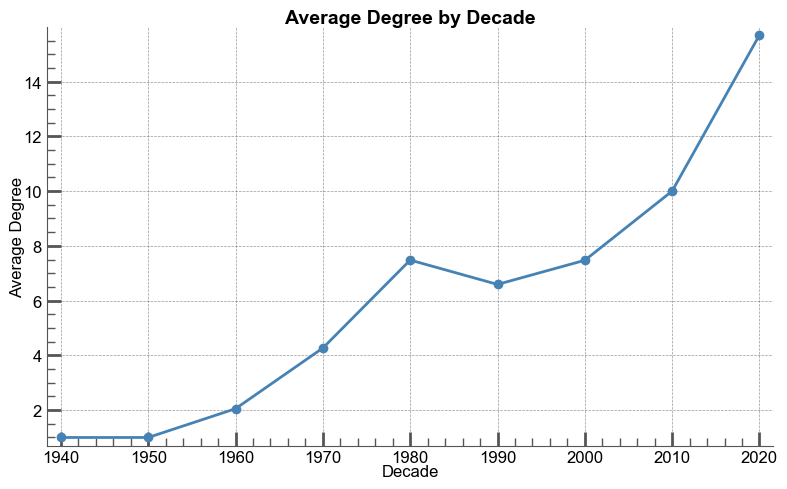

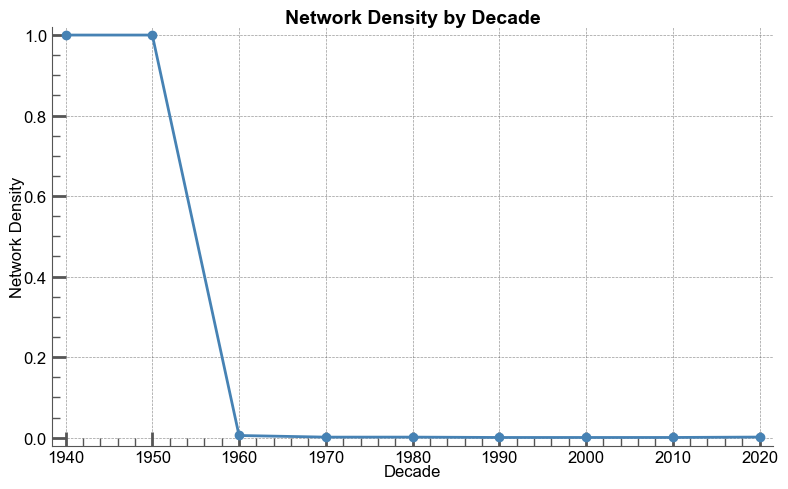

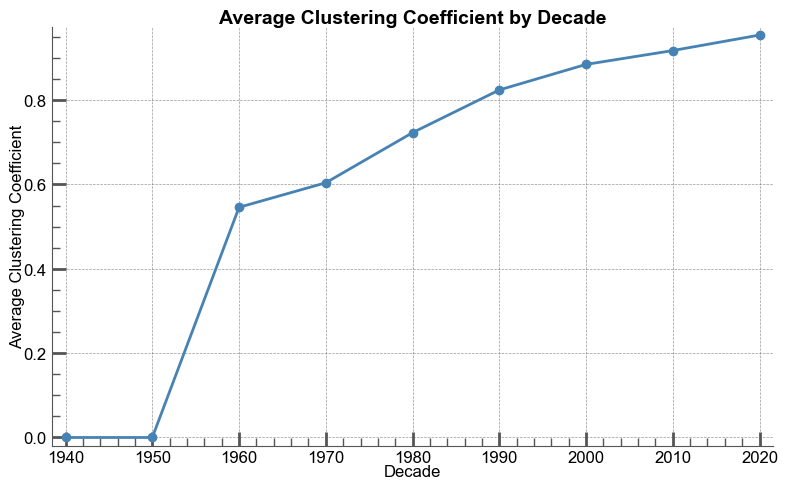

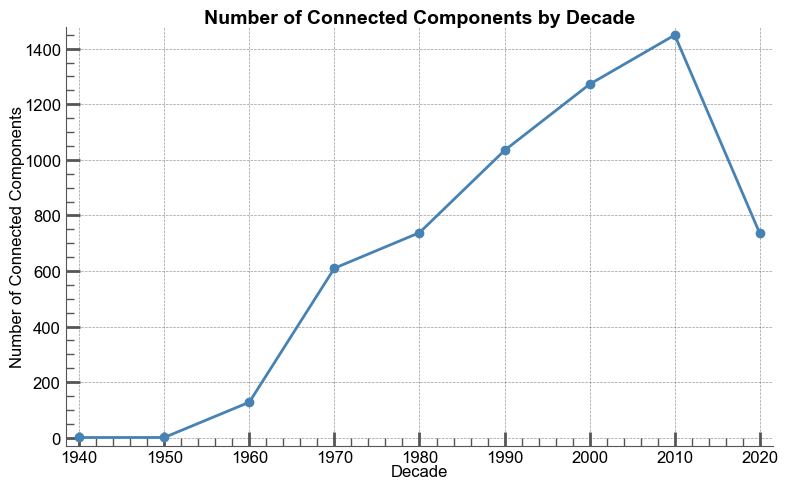

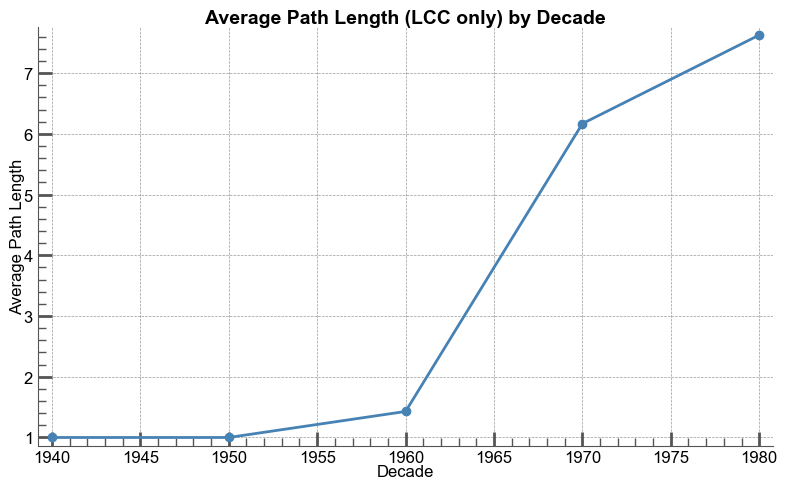

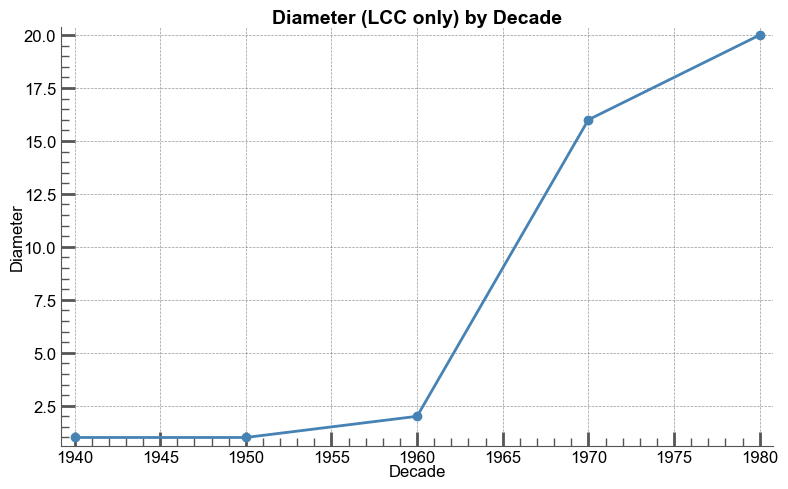

In [65]:
import matplotlib.pyplot as plt

metrics = [
    ("ratio_lcc", "Largest Connected Component (%)", lambda x: x * 100),
    ("size_lcc", "Size of Largest Connected Component", None),
    ("avg_degree", "Average Degree", None),
    ("density", "Network Density", None),
    ("avg_clustering", "Average Clustering Coefficient", None),
    ("num_components", "Number of Connected Components", None),
    ("avg_path_length", "Average Path Length (LCC only)", None),
    ("diameter", "Diameter (LCC only)", None),
]

# Generate one figure per metric
for col, title, transform in metrics:
    if col not in df_results.columns:
        continue  # skip missing metrics
    
    plt.figure(figsize=(8, 5))
    y = transform(df_results[col]) if transform else df_results[col]
    plt.plot(df_results["decade"], y, marker="o", linewidth=2, color="steelblue")
    
    plt.title(f"{title} by Decade", fontsize=14, fontweight="bold")
    plt.xlabel("Decade")
    plt.ylabel(title.split("(")[0].strip())
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


In [66]:
pairs_counter = {}
author_collab_totals = {}

for index_work, group in authors_bjp.group_by("index_work"):
    author_list = list(group["author_name"])
    if len(author_list) >= 2:
        for pair in itertools.combinations(sorted(author_list), 2):
            pairs_counter[pair] = pairs_counter.get(pair, 0) + 1
            author_collab_totals[pair[0]] = author_collab_totals.get(pair[0], 0) + 1
            author_collab_totals[pair[1]] = author_collab_totals.get(pair[1], 0) + 1

top_authors = sorted(author_collab_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_authors = [a for a, _ in top_authors]

author_ids = [aid for aid in top_authors if isinstance(aid, str)]

def fetch_authors(ids, batch_size=50):
    results = []
    for i in range(0, len(ids), batch_size):
        batch = ids[i:i+batch_size]
        res = list(alex.Authors()[batch])
        results.extend(res)
    return results

authors_info = fetch_authors(author_ids)

id_to_info = {}
for a in authors_info:
    inst_id, country = None, None
    if a.get("affiliations"):
        inst = a["affiliations"][0].get("institution")
        if inst:
            inst_id = inst.get("id")
            country = inst.get("country_code")
    id_to_info[a["id"]] = {
        "name": a.get("display_name"),
        "institution": inst_id,
        "country": country
    }

top_25_authors_df = pl.DataFrame({"author_id": author_ids})
top_25_authors_df = top_25_authors_df.with_columns([
    pl.col("author_id").map_elements(lambda aid: id_to_info.get(aid, {}).get("name"), return_dtype=pl.Utf8).alias("name"),
    pl.col("author_id").map_elements(lambda aid: id_to_info.get(aid, {}).get("institution"), return_dtype=pl.Utf8).alias("institution"),
    pl.col("author_id").map_elements(lambda aid: id_to_info.get(aid, {}).get("country"), return_dtype=pl.Utf8).alias("country"),
])




C:\Users\noahr\AppData\Local\Temp\ipykernel_7328\3119919372.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")
C:\Users\noahr\AppData\Local\Temp\ipykernel_7328\3119919372.py:36: UserWarning: Glyph 128105 (\N{WOMAN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\noahr\AppData\Local\Temp\ipykernel_7328\3119919372.py:36: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128105 (\N{WOMAN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) Arial

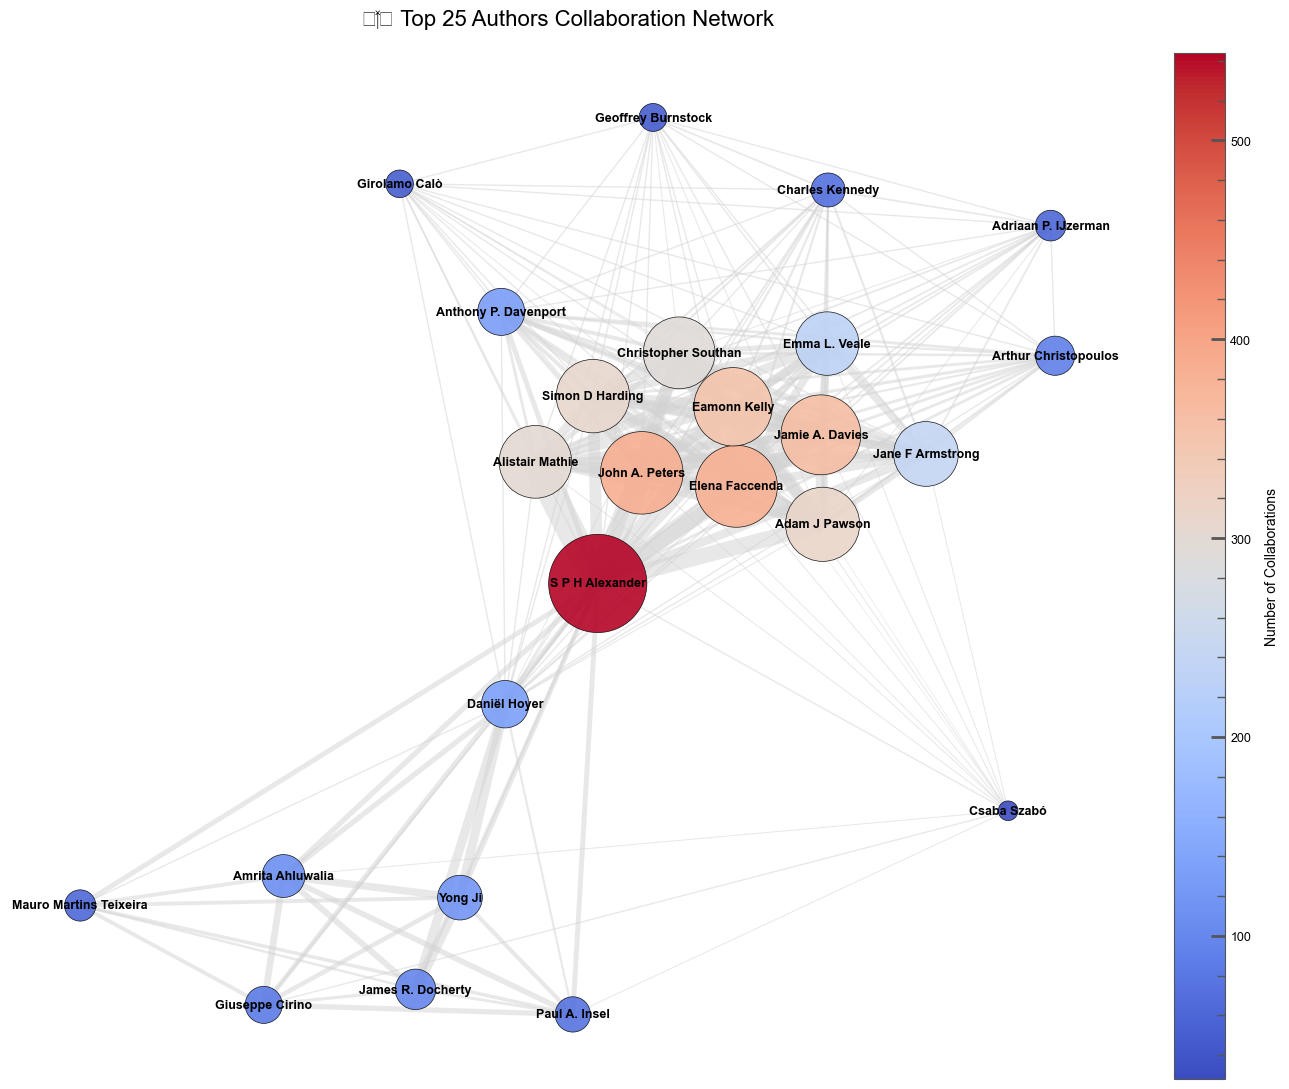

In [67]:
top_25_ids = set(top_25_authors_df["author_id"].to_list())
G = nx.Graph()

for (a1, a2), count in pairs_counter.items():
    if a1 in top_25_ids and a2 in top_25_ids and a1 != a2:
        G.add_edge(a1, a2, weight=count)

if len(G.nodes) > 0 and len(G.edges) > 0:
    node_vals = np.array([deg for node, deg in G.degree(weight='weight')])
    node_sizes = 200 + (node_vals - node_vals.min()) / (node_vals.max() - node_vals.min() + 1e-9) * (5000 - 200)

    edge_vals = np.array([G[u][v]['weight'] for u, v in G.edges()])
    edge_weights = 0.5 + (edge_vals - edge_vals.min()) / (edge_vals.max() - edge_vals.min() + 1e-9) * (20 - 0.5)

    cmap = cm.get_cmap("coolwarm")
    norm = mcolors.Normalize(vmin=node_vals.min(), vmax=node_vals.max())
    colors = cmap(norm(node_vals))

    pos = nx.spring_layout(G, k=1.1, weight='weight', seed=42)

    fig, ax = plt.subplots(figsize=(13, 11))
    nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, edge_color='lightgray', alpha=0.5)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, node_color=colors, alpha=0.9, edgecolors='black', linewidths=0.5)

    labels = {node: id_to_info.get(node, {}).get("name", node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, ax=ax, font_size=9, font_weight='bold')

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Number of Collaborations", fontsize=10, labelpad=10)

    ax.set_title("👩‍🔬 Top 25 Authors Collaboration Network", fontsize=16, pad=20)
    ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Aucun nœud ou arête à afficher pour ces top auteurs.")



In [68]:
pairs_counter = {}
author_collab_totals = {}

print(" Étape 1/3 : Comptage des collaborations")

authorsg_bjp = authorsg_bjp.with_columns([
    pl.col("author").fill_null("Unknown"),
    pl.col("country").fill_null("Unknown")
])

authors_pd = authorsg_bjp.to_pandas()
grouped = list(authors_pd.groupby("title"))

for title, group in tqdm(grouped, desc="Calcul collaborations", total=len(grouped)):
    author_list = list(group["author"])
    country_list = list(group["country"])
    if len(author_list) >= 2:
        for (a1, c1), (a2, c2) in itertools.combinations(sorted(zip(author_list, country_list)), 2):
            key = tuple(sorted([a1, a2]))
            pairs_counter[key] = pairs_counter.get(key, 0) + 1
            author_collab_totals[a1] = author_collab_totals.get(a1, 0) + 1
            author_collab_totals[a2] = author_collab_totals.get(a2, 0) + 1

print(f"✅ {len(pairs_counter):,} paires de collaborations enregistrées.")
print(f"✅ {len(author_collab_totals):,} auteurs uniques détectés.\n")


print("Étape 2/3 : Construction des nœuds et arêtes")

author_country_map = (
    authors_pd.groupby("author")["country"]
    .first()
    .to_dict()
)

edges = pd.DataFrame([
    {
        "source": a1,
        "target": a2,
        "weight": count,
        "source_country": author_country_map.get(a1, "Unknown"),
        "target_country": author_country_map.get(a2, "Unknown"),
    }
    for (a1, a2), count in pairs_counter.items()
])

nodes = pd.DataFrame({
    "id": list(author_collab_totals.keys()),
    "label": list(author_collab_totals.keys()),
    "collaborations": list(author_collab_totals.values()),
    "country": [author_country_map.get(a, "Unknown") for a in author_collab_totals.keys()]
})

print(f" {len(nodes):,} noeuds et {len(edges):,} arêtes prêts à être exportés.\n")

print(" Étape 3/3 : Export des fichiers CSV pour Gephi")

nodes.to_csv("nodes_bjp.csv", index=False)
edges.to_csv("edges_bjp.csv", index=False)

print("\n Export terminé avec succès")


 Étape 1/3 : Comptage des collaborations


Calcul collaborations: 100%|██████████| 23798/23798 [00:02<00:00, 8259.79it/s] 


✅ 342,018 paires de collaborations enregistrées.
✅ 62,675 auteurs uniques détectés.

Étape 2/3 : Construction des nœuds et arêtes
 62,675 noeuds et 342,018 arêtes prêts à être exportés.

 Étape 3/3 : Export des fichiers CSV pour Gephi

 Export terminé avec succès


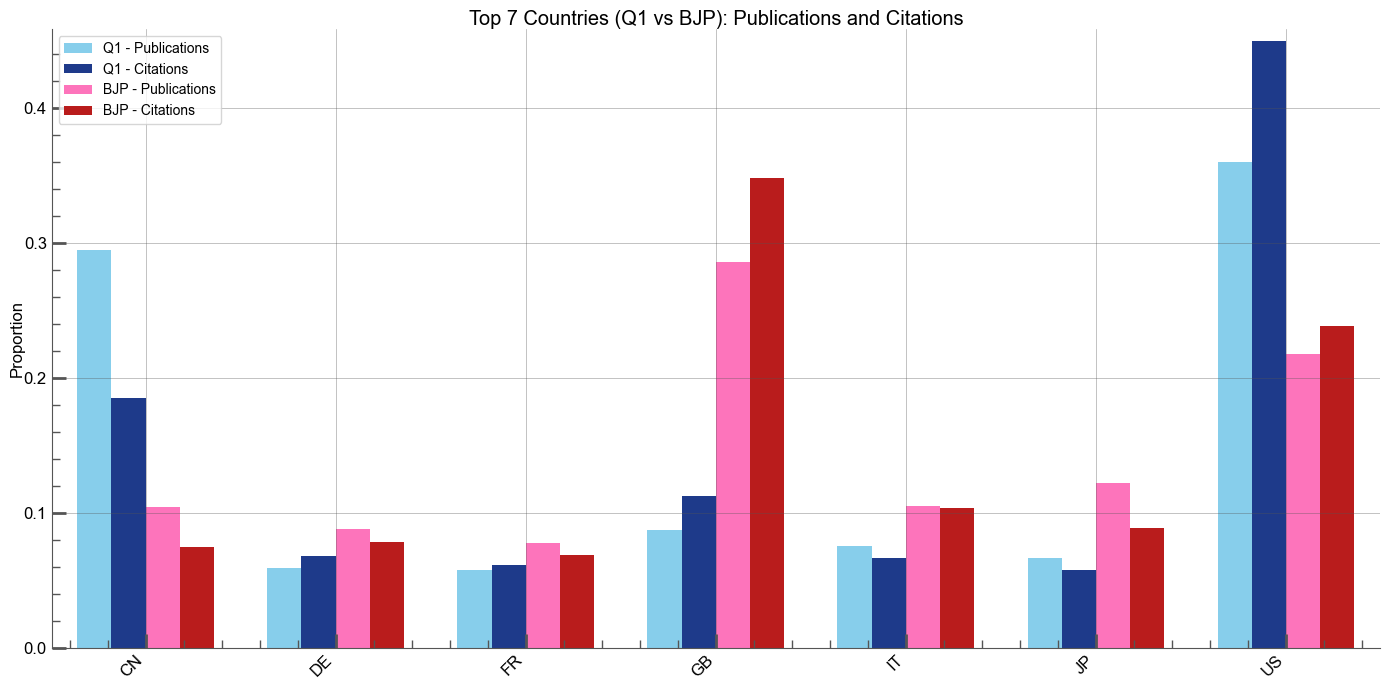

In [69]:
top_countries_q1 = (
    group_countries.sort("count", descending=True)
                   .head(7)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_q1 = group_countries.filter(pl.col("country_name").is_in(top_countries_q1)).to_pandas()
df_q1["prop_publications"] = df_q1["count"] / df_q1["count"].sum()
df_q1["prop_citations"] = df_q1["cited_by_count_mean"] * df_q1["count"]
df_q1["prop_citations"] /= df_q1["prop_citations"].sum()
df_q1["source"] = "Q1"

top_countries_bjp = (
    group_countries_bjp.sort("count", descending=True)
                       .head(7)
                       .select("country_name")
                       .to_series()
                       .to_list()
)

df_bjp = group_countries_bjp.filter(pl.col("country_name").is_in(top_countries_bjp)).to_pandas()
df_bjp["prop_publications"] = df_bjp["count"] / df_bjp["count"].sum()
df_bjp["prop_citations"] = df_bjp["cited_by_count_mean"] * df_bjp["count"]
df_bjp["prop_citations"] /= df_bjp["prop_citations"].sum()
df_bjp["source"] = "BJP"

df_all = pd.concat([df_q1, df_bjp], ignore_index=True)

fig, ax = plt.subplots(figsize=(14, 7))

countries = sorted(set(df_all["country_name"]))
x = range(len(countries))
width = 0.18  

def get_vals(df, metric, countries):
    return [df.loc[df["country_name"] == c, metric].values[0] if c in df["country_name"].values else 0 for c in countries]

df_q1_sub = df_all[df_all["source"] == "Q1"]
df_bjp_sub = df_all[df_all["source"] == "BJP"]

ax.bar([i - 1.5*width for i in x], get_vals(df_q1_sub, "prop_publications", countries), 
       width=width, label="Q1 - Publications", color="#87CEEB")  
ax.bar([i - 0.5*width for i in x], get_vals(df_q1_sub, "prop_citations", countries), 
       width=width, label="Q1 - Citations", color="#1E3A8A")  

ax.bar([i + 0.5*width for i in x], get_vals(df_bjp_sub, "prop_publications", countries), 
       width=width, label="BJP - Publications", color="#FD74BB")  
ax.bar([i + 1.5*width for i in x], get_vals(df_bjp_sub, "prop_citations", countries), 
       width=width, label="BJP - Citations", color="#B91C1C")  

ax.set_xticks(list(x))
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 7 Countries (Q1 vs BJP): Publications and Citations")
ax.legend()
plt.tight_layout()
plt.show()


In [70]:
import time


def fetch_authors(ids, batch_size=90, max_retries=3):
    results = []
    for i in range(0, len(ids), batch_size):
        batch = ids[i:i+batch_size]
        for attempt in range(max_retries):
            try:
                res = list(alex.Authors()[batch])
                for a in res:
                    if a is not None:
                        results.append(a)
                print(f"  Récupéré {min(i+batch_size, len(ids))}/{len(ids)} auteurs")
                break
            except Exception as e:
                print(f" Erreur lors de la récupération (tentative {attempt+1}) : {e}")
                time.sleep(2)
        else:
            print(f" Échec après {max_retries} tentatives pour batch {i}:{i+batch_size}")
    return results

all_results = []

# Boucle sur chaque année
for year in sorted(works["year"].unique().to_list()):
    print(f"\nAnnée {year}...")
    
    df_y = (
        works.filter(pl.col("year") == year)
        .select(["year", "cited_by_count", *cols_authors])
        .unpivot(
            on=cols_authors,
            index=["year", "cited_by_count"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
    )

    # Top 100 auteurs de l'année par citations
    top_authors_y = (
        df_y.group_by("author_id", maintain_order=True)
        .agg(pl.sum("cited_by_count").alias("total_citations"))
        .sort("total_citations", descending=True)
        .head(100)
    )

    author_ids = top_authors_y["author_id"].to_list()

    # Récupération des infos auteurs avec barre de progression
    print("Récupération des infos des auteurs depuis PyAlex...")
    authors_info = fetch_authors(author_ids, batch_size=90)

    # Mapping ID → infos (nom et citations) avec gestion des None
    id_to_info = {}
    for a in authors_info:
        try:
            author_id = a["id"]
            id_to_info[author_id] = {
                "name": a.get("display_name", "Unknown"),
                "citations": a.get("cited_by_count", 0)
            }
        except TypeError:
            continue  # ignore si a est None

    # Ajouter noms et citations PyAlex avec valeurs par défaut
    top_authors_y = top_authors_y.with_columns([
        pl.col("author_id").map_elements(
            lambda aid: id_to_info.get(aid, {}).get("name", "Unknown"), 
            return_dtype=pl.Utf8
        ).alias("name"),
        pl.col("author_id").map_elements(
            lambda aid: id_to_info.get(aid, {}).get("citations", 0), 
            return_dtype=pl.Int64
        ).alias("author_total_citations"),
        pl.lit(year).alias("year")
    ])

    all_results.append(top_authors_y)

# Concaténation finale
top_authors_per_year = pl.concat(all_results)

print("\n✅ Récupération terminée !")



Année 1909...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 24/24 auteurs

Année 1910...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 44/44 auteurs

Année 1911...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 28/28 auteurs

Année 1912...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 36/36 auteurs

Année 1913...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 45/45 auteurs

Année 1914...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 49/49 auteurs

Année 1915...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 63/63 auteurs

Année 1916...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 52/52 auteurs

Année 1917...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 55/55 auteurs

Année 1918...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 51/51 auteurs

Année 1919...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 63

KeyboardInterrupt: 

In [ ]:
all_results = []

# Boucle sur chaque année
for year in sorted(works_bjp["year"].unique().to_list()):
    print(f"\nAnnée {year}...")
    
    df_y = (
        works_bjp.filter(pl.col("year") == year)
        .select(["year", "cited_by_count", *bjp_cols_authors])
        .unpivot(
            on=bjp_cols_authors,
            index=["year", "cited_by_count"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
    )

    # Top 100 auteurs de l'année par citations
    top_authors_y = (
        df_y.group_by("author_id", maintain_order=True)
        .agg(pl.sum("cited_by_count").alias("total_citations"))
        .sort("total_citations", descending=True)
        .head(100)
    )

    author_ids = top_authors_y["author_id"].to_list()

    # Récupération des infos auteurs avec barre de progression
    print("Récupération des infos des auteurs depuis PyAlex...")
    authors_info = fetch_authors(author_ids, batch_size=75)

    # Mapping ID → infos (nom et citations) avec gestion des None
    id_to_info = {}
    for a in authors_info:
        try:
            author_id = a["id"]
            id_to_info[author_id] = {
                "name": a.get("display_name", "Unknown"),
                "citations": a.get("cited_by_count", 0)
            }
        except TypeError:
            continue  # ignore si a est None

    # Ajouter noms et citations PyAlex avec valeurs par défaut
    top_authors_y = top_authors_y.with_columns([
        pl.col("author_id").map_elements(
            lambda aid: id_to_info.get(aid, {}).get("name", "Unknown"), 
            return_dtype=pl.Utf8
        ).alias("name"),
        pl.col("author_id").map_elements(
            lambda aid: id_to_info.get(aid, {}).get("citations", 0), 
            return_dtype=pl.Int64
        ).alias("author_total_citations"),
        pl.lit(year).alias("year")
    ])

    all_results.append(top_authors_y)

# Concaténation finale
top_authors_per_year_bjp = pl.concat(all_results)

print("\n✅ Récupération terminée !")


Année 1948...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 3/3 auteurs

Année 1950...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 2/2 auteurs

Année 1968...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 75/100 auteurs
  Récupéré 100/100 auteurs

Année 1969...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 75/100 auteurs
  Récupéré 100/100 auteurs

Année 1970...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 75/100 auteurs
  Récupéré 100/100 auteurs

Année 1971...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 75/100 auteurs
  Récupéré 100/100 auteurs

Année 1972...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 75/100 auteurs
  Récupéré 100/100 auteurs

Année 1973...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 75/100 auteurs
  Récupéré 100/100 auteurs

Année 1974...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 75/100 auteurs
  Récup

In [ ]:
top_authors_per_year

author_id,total_citations,name,author_total_citations,year
str,i64,str,i64,i32
"""https://openalex.org/A51102708…",47,"""John J. Abel""",1241,1909
"""https://openalex.org/A50329477…",47,"""Leonard G. Rowntree""",2026,1909
"""https://openalex.org/A51116416…",20,"""CHARLES W. EDMUNDS""",284,1909
"""https://openalex.org/A51121624…",15,"""Don R. Joseph""",166,1909
"""https://openalex.org/A50802778…",15,"""S. J. Meltzer""",4358,1909
…,…,…,…,…
"""https://openalex.org/A50768261…",129,"""Myriam Salem""",820,2024
"""https://openalex.org/A50082011…",128,"""Lauren M. Aleksunes""",8714,2024
"""https://openalex.org/A50182560…",128,"""Xiaohe Xiao""",9961,2024


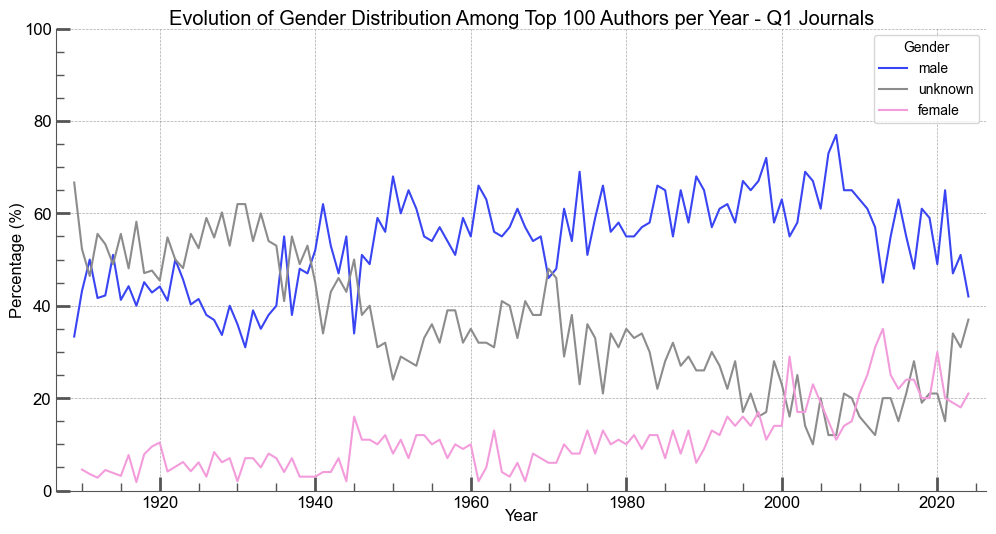

In [ ]:
d = gender.Detector()

def build_gender_df_per_year(df):
    records = []
    for year, group in df.groupby("year"):
        first_names = extract_first_names(group["name"].to_list())
        for name in first_names:
            if name:
                g = normalize_gender(d.get_gender(name))
            else:
                g = "unknown"
            records.append({"year": year, "gender": g})
    return pd.DataFrame(records)

df_top_authors_pd = top_authors_per_year.to_pandas()

df_gender_all = build_gender_df_per_year(df_top_authors_pd)
gender_counts = (
    df_gender_all.groupby(["year", "gender"])
    .size()
    .reset_index(name="count")
)

total_per_year = df_gender_all.groupby("year").size().reset_index(name="total")
gender_counts = gender_counts.merge(total_per_year, on="year")
gender_counts["percent"] = 100 * gender_counts["count"] / gender_counts["total"]

plt.figure(figsize=(12,6))
sns.lineplot(data=gender_counts, x="year", y="percent", hue="gender",palette={"male":"#3944f3", "female":"#f39cdb", "unknown":"#8c8c8c"})
plt.title("Evolution of Gender Distribution Among Top 100 Authors per Year - Q1 Journals") 
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.ylim(0,100)
plt.legend(title="Gender")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
top_authors_per_year_bjp

author_id,total_citations,name,author_total_citations,year
str,i64,str,i64,i32
"""https://openalex.org/A51142497…",7,"""G.G. Brownlee""",15029,1948
"""https://openalex.org/A50205694…",7,"""Cynthia Kennedy""",39,1948
"""https://openalex.org/A51085631…",0,"""J. D. Fulton""",1925,1948
"""https://openalex.org/A50863853…",19,"""F. H. S. Curd""",943,1950
"""https://openalex.org/A51128128…",19,"""D. G. Davey""",689,1950
…,…,…,…,…
"""https://openalex.org/A50356639…",12,"""Baerbel Laemmle""",20,2024
"""https://openalex.org/A51075844…",12,"""Muath Bajarwan""",17,2024
"""https://openalex.org/A50531333…",12,"""Karsten Quast""",756,2024


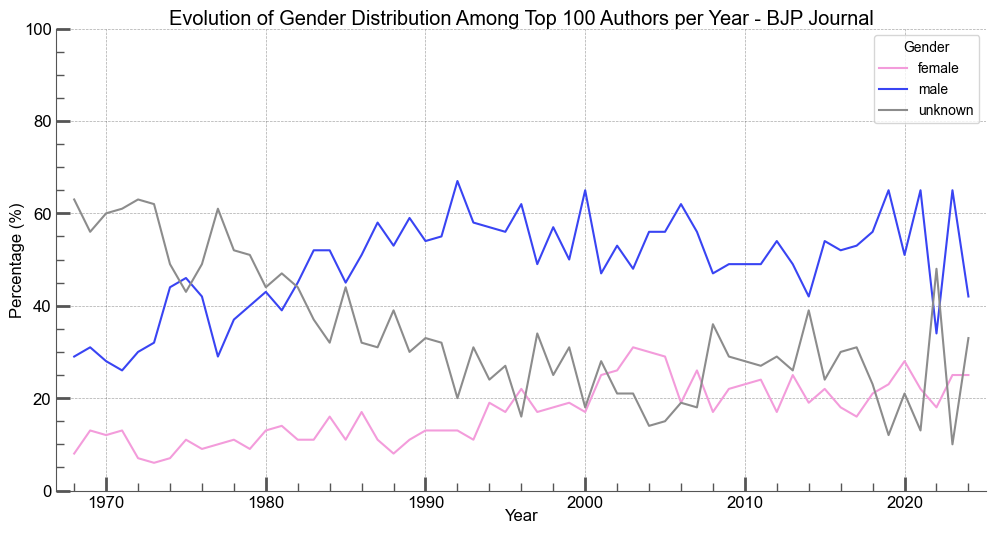

In [ ]:
d = gender.Detector()


top_authors_filtered = top_authors_per_year_bjp.filter(
    ~pl.col("year").is_in([1948, 1950])
)

df_top_authors_pd = top_authors_filtered.to_pandas()

df_gender_all = build_gender_df_per_year(df_top_authors_pd)
gender_counts = (
    df_gender_all.groupby(["year", "gender"])
    .size()
    .reset_index(name="count")
)

total_per_year = df_gender_all.groupby("year").size().reset_index(name="total")
gender_counts = gender_counts.merge(total_per_year, on="year")
gender_counts["percent"] = 100 * gender_counts["count"] / gender_counts["total"]

plt.figure(figsize=(12,6))
sns.lineplot(data=gender_counts, x="year", y="percent", hue="gender",palette={"male":"#3944f3", "female":"#f39cdb", "unknown":"#8c8c8c"})
plt.title("Evolution of Gender Distribution Among Top 100 Authors per Year - BJP Journal") 
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.ylim(0,100)
plt.legend(title="Gender")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
all_results = []

# Boucle sur chaque année
for year in sorted(works["year"].unique().to_list()):
    print(f"\nAnnée {year}...")

    df_y = (
        works.filter(pl.col("year") == year)
        .select(["year", "cited_by_count", *cols_authors])
        .unpivot(
            on=cols_authors,
            index=["year", "cited_by_count"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
    )

    # Top 100 auteurs de l'année par activité (nombre de publications)
    top_authors_y = (
        df_y.group_by("author_id", maintain_order=True)
        .agg(pl.count("cited_by_count").alias("num_publications"))
        .sort("num_publications", descending=True)
        .head(100)
    )

    author_ids = top_authors_y["author_id"].to_list()

    # Récupération des infos auteurs
    print("Récupération des infos des auteurs depuis PyAlex...")
    authors_info = fetch_authors(author_ids, batch_size=90)

    # Mapping ID → infos (nom et citations) avec gestion des None
    id_to_info = {}
    for a in authors_info:
        try:
            author_id = a["id"]
            id_to_info[author_id] = {
                "name": a.get("display_name", "Unknown"),
                "citations": a.get("cited_by_count", 0)
            }
        except TypeError:
            continue

    # Ajouter noms et citations PyAlex avec valeurs par défaut
    top_authors_y = top_authors_y.with_columns([
        pl.col("author_id").map_elements(
            lambda aid: id_to_info.get(aid, {}).get("name", "Unknown"), 
            return_dtype=pl.Utf8
        ).alias("name"),
        pl.col("author_id").map_elements(
            lambda aid: id_to_info.get(aid, {}).get("citations", 0), 
            return_dtype=pl.Int64
        ).alias("author_total_citations"),
        pl.lit(year).alias("year")
    ])

    all_results.append(top_authors_y)

# Concaténation finale
top_authors_per_year = pl.concat(all_results)

print("\n✅ Récupération terminée !")


Année 1909...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 24/24 auteurs

Année 1910...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 44/44 auteurs

Année 1911...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 28/28 auteurs

Année 1912...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 36/36 auteurs

Année 1913...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 45/45 auteurs

Année 1914...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 49/49 auteurs

Année 1915...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 63/63 auteurs

Année 1916...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 52/52 auteurs

Année 1917...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 55/55 auteurs

Année 1918...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 51/51 auteurs

Année 1919...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 63

In [ ]:
all_results = []

# Boucle sur chaque année
for year in sorted(works_bjp["year"].unique().to_list()):
    print(f"\nAnnée {year}...")

    df_y = (
        works_bjp.filter(pl.col("year") == year)
        .select(["year", "cited_by_count", *bjp_cols_authors])
        .unpivot(
            on=bjp_cols_authors,
            index=["year", "cited_by_count"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
    )

    # Top 100 auteurs de l'année par activité (nombre de publications)
    top_authors_y = (
        df_y.group_by("author_id", maintain_order=True)
        .agg(pl.count("cited_by_count").alias("num_publications"))
        .sort("num_publications", descending=True)
        .head(100)
    )

    author_ids = top_authors_y["author_id"].to_list()

    # Récupération des infos auteurs
    print("Récupération des infos des auteurs depuis PyAlex...")
    authors_info = fetch_authors(author_ids, batch_size=90)

    # Mapping ID → infos (nom et citations) avec gestion des None
    id_to_info = {}
    for a in authors_info:
        try:
            author_id = a["id"]
            id_to_info[author_id] = {
                "name": a.get("display_name", "Unknown"),
                "citations": a.get("cited_by_count", 0)
            }
        except TypeError:
            continue

    # Ajouter noms et citations PyAlex avec valeurs par défaut
    top_authors_y = top_authors_y.with_columns([
        pl.col("author_id").map_elements(
            lambda aid: id_to_info.get(aid, {}).get("name", "Unknown"), 
            return_dtype=pl.Utf8
        ).alias("name"),
        pl.col("author_id").map_elements(
            lambda aid: id_to_info.get(aid, {}).get("citations", 0), 
            return_dtype=pl.Int64
        ).alias("author_total_citations"),
        pl.lit(year).alias("year")
    ])

    all_results.append(top_authors_y)

# Concaténation finale
top_authors_per_year_bjp = pl.concat(all_results)

print("\n✅ Récupération terminée !")


Année 1948...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 3/3 auteurs

Année 1950...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 2/2 auteurs

Année 1968...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 90/100 auteurs
  Récupéré 100/100 auteurs

Année 1969...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 90/100 auteurs
  Récupéré 100/100 auteurs

Année 1970...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 90/100 auteurs
  Récupéré 100/100 auteurs

Année 1971...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 90/100 auteurs
  Récupéré 100/100 auteurs

Année 1972...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 90/100 auteurs
  Récupéré 100/100 auteurs

Année 1973...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 90/100 auteurs
  Récupéré 100/100 auteurs

Année 1974...
Récupération des infos des auteurs depuis PyAlex...
  Récupéré 90/100 auteurs
  Récup

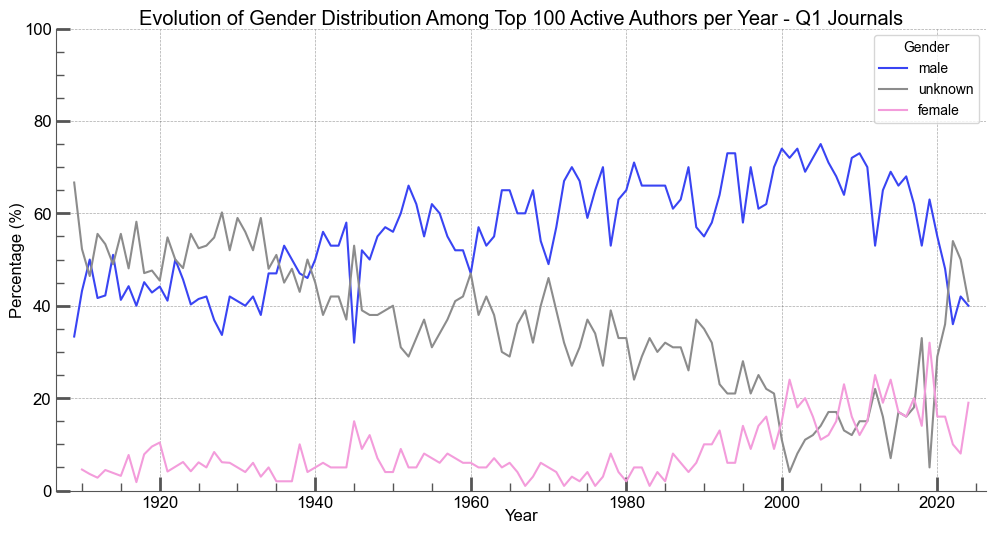

In [ ]:
d = gender.Detector()

df_top_authors_pd = top_authors_per_year.to_pandas()

df_gender_all = build_gender_df_per_year(df_top_authors_pd)
gender_counts = (
    df_gender_all.groupby(["year", "gender"])
    .size()
    .reset_index(name="count")
)

total_per_year = df_gender_all.groupby("year").size().reset_index(name="total")
gender_counts = gender_counts.merge(total_per_year, on="year")
gender_counts["percent"] = 100 * gender_counts["count"] / gender_counts["total"]

plt.figure(figsize=(12,6))
sns.lineplot(data=gender_counts, x="year", y="percent", hue="gender",palette={"male":"#3944f3", "female":"#f39cdb", "unknown":"#8c8c8c"})
plt.title("Evolution of Gender Distribution Among Top 100 Active Authors per Year - Q1 Journals") 
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.ylim(0,100)
plt.legend(title="Gender")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


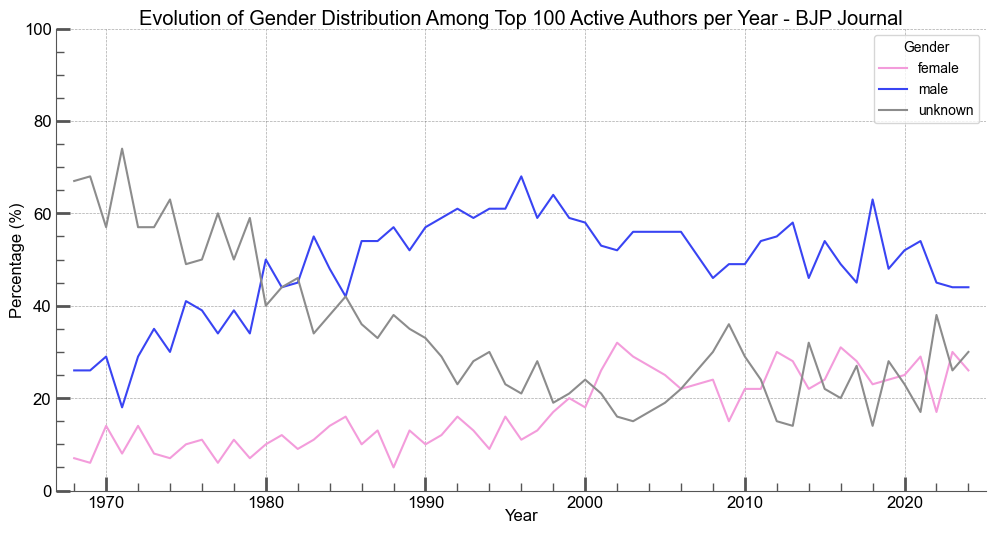

In [ ]:
d = gender.Detector()

top_authors_filtered = top_authors_per_year_bjp.filter(
    ~pl.col("year").is_in([1948, 1950])
)

df_top_authors_pd = top_authors_filtered.to_pandas()

df_gender_all = build_gender_df_per_year(df_top_authors_pd)
gender_counts = (
    df_gender_all.groupby(["year", "gender"])
    .size()
    .reset_index(name="count")
)

total_per_year = df_gender_all.groupby("year").size().reset_index(name="total")
gender_counts = gender_counts.merge(total_per_year, on="year")
gender_counts["percent"] = 100 * gender_counts["count"] / gender_counts["total"]

plt.figure(figsize=(12,6))
sns.lineplot(data=gender_counts, x="year", y="percent", hue="gender",palette={"male":"#3944f3", "female":"#f39cdb", "unknown":"#8c8c8c"})
plt.title("Evolution of Gender Distribution Among Top 100 Active Authors per Year - BJP Journal") 
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.ylim(0,100)
plt.legend(title="Gender")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
import bar_chart_race as bcr

print(works["year"].min(), works["year"].max())

authors_global = (
        works
        .select(["year", *cols_authors, "cited_by_count"])
        .unpivot(
            on=cols_authors,
            index=["year", "cited_by_count"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
        .group_by("author_id")
        .agg(pl.sum("cited_by_count").alias("total_citations"))
        .sort("total_citations", descending=True)
)

top_authors_ids = authors_global.head(10)["author_id"].to_list()

authors_info = fetch_authors(top_authors_ids, batch_size=90)

id_to_name = {a["id"]: a.get("display_name", "Unknown") for a in authors_info if a is not None}

df_top = (
    works
    .select(["year", *cols_authors, "cited_by_count"])
    .unpivot(
        on=cols_authors,
        index=["year", "cited_by_count"],
        variable_name="author_pos",
        value_name="author_id"
    )
    .filter(pl.col("author_id").is_in(top_authors_ids))
)
df_top = df_top.with_columns(
    pl.col("author_id").map_elements(lambda aid: id_to_name.get(aid, "Unknown"), return_dtype=pl.Utf8).alias("name")
)

df_yearly = (
        df_top.group_by(["year", "name"])
        .agg(pl.sum("cited_by_count").alias("value"))
        .sort(["year", "value"], descending=[False, True])
)

authors_pivot = df_yearly.pivot(
    index="year",
    columns="name",
    values="value",
    aggregate_function="sum"
).fill_null(0).sort("year")

authors_pivot_pd = authors_pivot.to_pandas().set_index("year")
authors_pivot_pd.index = pd.PeriodIndex(authors_pivot_pd.index, freq="Y").to_timestamp()

authors_pivot_cumsum = authors_pivot_pd.cumsum()

bcr.bar_chart_race(
    df=authors_pivot_cumsum,
    filename='../results/q1/authors/top_authors_q1_cumulative.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title=f'The changing ranks of the Top 10 authors in 2024 - Q1 by citations',
    bar_size=.95,
    interpolate_period=True
)

1909 2024
  Récupéré 10/10 auteurs


C:\Users\noahr\AppData\Local\Temp\ipykernel_15776\752535601.py:47: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  authors_pivot = df_yearly.pivot(
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(self.df_values.columns)
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:287: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:297: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO(), format='png')
C:\Users\no

In [ ]:



authors_global = (
        works_bjp
        .select(["year", *bjp_cols_authors, "cited_by_count"])
        .unpivot(
            on=bjp_cols_authors,
            index=["year", "cited_by_count"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
        .group_by("author_id")
        .agg(pl.sum("cited_by_count").alias("total_citations"))
        .sort("total_citations", descending=True)
)

top_authors_ids = authors_global.head(10)["author_id"].to_list()

authors_info = fetch_authors(top_authors_ids, batch_size=90)

id_to_name = {a["id"]: a.get("display_name", "Unknown") for a in authors_info if a is not None}

df_top = (
    works_bjp
    .select(["year", *bjp_cols_authors, "cited_by_count"])
    .unpivot(
        on=bjp_cols_authors,
        index=["year", "cited_by_count"],
        variable_name="author_pos",
        value_name="author_id"
    )
    .filter(pl.col("author_id").is_in(top_authors_ids))
)
df_top = df_top.with_columns(
    pl.col("author_id").map_elements(lambda aid: id_to_name.get(aid, "Unknown"), return_dtype=pl.Utf8).alias("name")
)

df_yearly = (
        df_top.group_by(["year", "name"])
        .agg(pl.sum("cited_by_count").alias("value"))
        .sort(["year", "value"], descending=[False, True])
)

authors_pivot = df_yearly.pivot(
    index="year",
    columns="name",
    values="value",
    aggregate_function="sum"
).fill_null(0).sort("year")

authors_pivot_pd = authors_pivot.to_pandas().set_index("year")
authors_pivot_pd.index = pd.PeriodIndex(authors_pivot_pd.index, freq="Y").to_timestamp()

authors_pivot_cumsum = authors_pivot_pd.cumsum()

bcr.bar_chart_race(
    df=authors_pivot_cumsum,
    filename='../results/bjp/authors/top_authors_bjp_cumulative.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title=f'The changing ranks of the Top 10 authors in 2024 - BJP by Citations',
    bar_size=.95,
    interpolate_period=True
)


  Récupéré 10/10 auteurs


C:\Users\noahr\AppData\Local\Temp\ipykernel_15776\3811192823.py:43: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  authors_pivot = df_yearly.pivot(
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(self.df_values.columns)
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:287: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


In [ ]:
import bar_chart_race as bcr

authors_global = (
        works
        .select(["year", *cols_authors])
        .unpivot(
            on=cols_authors,
            index=["year"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
        .group_by("author_id")
        .agg(pl.count("author_id").alias("total_publications"))
        .sort("total_publications", descending=True)
)
    
top_authors_ids = authors_global.head(11)["author_id"].to_list()

authors_info = fetch_authors(top_authors_ids, batch_size=90)

id_to_name = {a["id"]: a.get("display_name", "Unknown") for a in authors_info if a is not None}

df_top = (
    works
    .select(["year", *cols_authors, "cited_by_count"])
    .unpivot(
        on=cols_authors,
        index=["year", "cited_by_count"],
        variable_name="author_pos",
        value_name="author_id"
    )
    .filter(pl.col("author_id").is_in(top_authors_ids))
)
df_top = df_top.with_columns(
    pl.col("author_id").map_elements(lambda aid: id_to_name.get(aid, "Unknown"), return_dtype=pl.Utf8).alias("name")
)

df_yearly = (
        df_top.group_by(["year", "name"])
        .agg(pl.count("author_id").alias("value"))
        .sort(["year", "value"], descending=[False, True])
)

authors_pivot = (
    df_yearly
    .filter(pl.col("name") != "Unknown")
    .pivot(
        index="year",
        columns="name",
        values="value",
        aggregate_function="sum"
    )
    .fill_null(0)
    .sort("year")
)

authors_pivot_pd = authors_pivot.to_pandas().set_index("year")
authors_pivot_pd.index = pd.PeriodIndex(authors_pivot_pd.index, freq="Y").to_timestamp()

authors_pivot_cumsum = authors_pivot_pd.cumsum()

bcr.bar_chart_race(
    df=authors_pivot_cumsum,
    filename='../results/q1/authors/active_authors_q1_cumulative.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title=f'The changing ranks of the Top 10 authors in 2024 - Q1 by Publications',
    bar_size=.95,
    interpolate_period=True
)

  Récupéré 11/11 auteurs


C:\Users\noahr\AppData\Local\Temp\ipykernel_15776\3498075338.py:48: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(self.df_values.columns)
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:287: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


In [ ]:
import bar_chart_race as bcr

authors_global = (
        works_bjp
        .select(["year", *bjp_cols_authors])
        .unpivot(
            on=bjp_cols_authors,
            index=["year"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
        .group_by("author_id")
        .agg(pl.count("author_id").alias("total_publications"))
        .sort("total_publications", descending=True)
)
    
top_authors_ids = authors_global.head(10)["author_id"].to_list()

authors_info = fetch_authors(top_authors_ids, batch_size=90)

id_to_name = {a["id"]: a.get("display_name", "Unknown") for a in authors_info if a is not None}

df_top = (
    works_bjp
    .select(["year", *bjp_cols_authors, "cited_by_count"])
    .unpivot(
        on=bjp_cols_authors,
        index=["year", "cited_by_count"],
        variable_name="author_pos",
        value_name="author_id"
    )
    .filter(pl.col("author_id").is_in(top_authors_ids))
)
df_top = df_top.with_columns(
    pl.col("author_id").map_elements(lambda aid: id_to_name.get(aid, "Unknown"), return_dtype=pl.Utf8).alias("name")
)

df_yearly = (
        df_top.group_by(["year", "name"])
        .agg(pl.count("author_id").alias("value"))
        .sort(["year", "value"], descending=[False, True])
)

authors_pivot = df_yearly.pivot(
    index="year",
    columns="name",
    values="value",
    aggregate_function="sum"
).fill_null(0).sort("year")

authors_pivot_pd = authors_pivot.to_pandas().set_index("year")
authors_pivot_pd.index = pd.PeriodIndex(authors_pivot_pd.index, freq="Y").to_timestamp()

authors_pivot_cumsum = authors_pivot_pd.cumsum()

bcr.bar_chart_race(
    df=authors_pivot_cumsum,
    filename='../results/bjp/authors/active_authors_bjp_cumulative.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title=f'The changing ranks of the Top 10 authors in 2024 - BJP by Publications',
    bar_size=.95,
    interpolate_period=True
)



  Récupéré 10/10 auteurs


C:\Users\noahr\AppData\Local\Temp\ipykernel_15776\1651835747.py:45: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  authors_pivot = df_yearly.pivot(
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(self.df_values.columns)
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:287: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


In [ ]:
all_results = []

for year in sorted(works["year"].unique().to_list()):
    df_y = (
        works.filter(pl.col("year") == year)
        .select(["year", "cited_by_count", *cols_authors])
        .unpivot(
            on=cols_authors,
            index=["year", "cited_by_count"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
    )

    top_authors_y = (
        df_y.group_by("author_id")
        .agg(pl.sum("cited_by_count")
             .alias("value"))
        .sort("value", descending=True).head(1500)
    )

    all_results.append(top_authors_y.with_columns(pl.lit(year).alias("year")))

df_top_yearly = pl.concat(all_results)

unique_ids = df_top_yearly["author_id"].unique().to_list()
authors_info = fetch_authors(unique_ids, batch_size=90)
id_to_name = {a["id"]: a.get("display_name", "Unknown") for a in authors_info if a is not None}

df_top_yearly = df_top_yearly.with_columns(
    pl.col("author_id").map_elements(lambda aid: id_to_name.get(aid, "Unknown"), return_dtype=pl.Utf8).alias("name")
)




  Récupéré 90/65691 auteurs
  Récupéré 180/65691 auteurs
  Récupéré 270/65691 auteurs
  Récupéré 360/65691 auteurs
  Récupéré 450/65691 auteurs
  Récupéré 540/65691 auteurs
  Récupéré 630/65691 auteurs
  Récupéré 720/65691 auteurs
  Récupéré 810/65691 auteurs
  Récupéré 900/65691 auteurs
  Récupéré 990/65691 auteurs
  Récupéré 1080/65691 auteurs
  Récupéré 1170/65691 auteurs
  Récupéré 1260/65691 auteurs
  Récupéré 1350/65691 auteurs
  Récupéré 1440/65691 auteurs
  Récupéré 1530/65691 auteurs
  Récupéré 1620/65691 auteurs
  Récupéré 1710/65691 auteurs
  Récupéré 1800/65691 auteurs
  Récupéré 1890/65691 auteurs
  Récupéré 1980/65691 auteurs
  Récupéré 2070/65691 auteurs
  Récupéré 2160/65691 auteurs
  Récupéré 2250/65691 auteurs
  Récupéré 2340/65691 auteurs
  Récupéré 2430/65691 auteurs
  Récupéré 2520/65691 auteurs
  Récupéré 2610/65691 auteurs
  Récupéré 2700/65691 auteurs
  Récupéré 2790/65691 auteurs
  Récupéré 2880/65691 auteurs
  Récupéré 2970/65691 auteurs
  Récupéré 3060/65691 

In [ ]:

top10_per_year = (
    df_top_yearly
    .sort(["year", "value"], descending=[False, True])
    .group_by("year")
    .head(10)
)

top10_authors = top10_per_year["author_id"].unique().to_list()

df_top_filtered = df_top_yearly.filter(pl.col("author_id").is_in(top10_authors))

authors_pivot = df_top_filtered.pivot(
    index="year",
    columns="name",
    values="value",
    aggregate_function="sum"
).fill_null(0).sort("year")

authors_pivot_pd = authors_pivot.to_pandas().set_index("year")
authors_pivot_pd.index = pd.PeriodIndex(authors_pivot_pd.index, freq="Y").to_timestamp()

authors_pivot_cumsum = authors_pivot_pd.cumsum()

bcr.bar_chart_race(
    df=authors_pivot_cumsum,
    filename='../results/q1/authors/top10_q1_authors_evo.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='The evolution of the Top 10 most cited authors over the years - Q1 Journals',
    bar_size=.95,
    interpolate_period=True
)

C:\Users\noahr\AppData\Local\Temp\ipykernel_15776\348396918.py:12: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  authors_pivot = df_top_filtered.pivot(
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 127 () missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 129 (\x81) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 130 (\x82) missing from font(s) Arial.
  fig.canvas.print_figure(io.Bytes

In [ ]:
df_top_pd = df_top_filtered.to_pandas().sort_values(["name", "year"])


df_top_pd["rolling_5y"] = (
    df_top_pd.groupby("name")["value"]
    .rolling(5, min_periods=1)  
    .sum()
    .reset_index(level=0, drop=True)
)

df_top_pd_grouped = df_top_pd.groupby(["year", "name"], as_index=False)["rolling_5y"].sum()

pivot_5y = df_top_pd_grouped.pivot(index="year", columns="name", values="rolling_5y").fillna(0)

years = pivot_5y.index
pivot_5y.index = [f"({y-4}–{y})" for y in years]

bcr.bar_chart_race(
    df=pivot_5y,
    filename='../results/q1/authors/top10_q1_authors_evo_5y.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=50,
    period_length=3000,
    title='The evolution of the Top 10 most cited authors over the years (5-year period) - Q1 Journals',
    bar_size=.95,
    interpolate_period=True
)



C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:887: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_values.iloc[:, 0] = df_values.iloc[:, 0].interpolate()
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 127 () missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:284: UserWarning: Glyph 129 (\x81) missing from font(s) Arial.
  fig.canvas.print_figure(io.BytesIO())
C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\bar_chart_race\_make_chart.py:28

Exception: You do not have ffmpeg installed on your machine. Download
                            ffmpeg from here: https://www.ffmpeg.org/download.html.
                            
                            Matplotlib's original error message below:

                            bad allocation
                            

In [ ]:
all_results = []

for year in sorted(works_bjp["year"].unique().to_list()):
    df_y = (
        works_bjp.filter(pl.col("year") == year)
        .select(["year", "cited_by_count", *bjp_cols_authors])
        .unpivot(
            on=bjp_cols_authors,
            index=["year", "cited_by_count"],
            variable_name="author_pos",
            value_name="author_id"
        )
        .filter(pl.col("author_id").is_not_null())
    )

    top_authors_y = (
        df_y.group_by("author_id").agg(pl.sum("cited_by_count").alias("value")).sort("value", descending=True).head(1500)
    )

    all_results.append(top_authors_y.with_columns(pl.lit(year).alias("year")))

df_top_yearly = pl.concat(all_results)

unique_ids = df_top_yearly["author_id"].unique().to_list()
authors_info = fetch_authors(unique_ids, batch_size=90)
id_to_name = {a["id"]: a.get("display_name", "Unknown") for a in authors_info if a is not None}

df_top_yearly = df_top_yearly.with_columns(
    pl.col("author_id").map_elements(lambda aid: id_to_name.get(aid, "Unknown"), return_dtype=pl.Utf8).alias("name")
)

  Récupéré 90/43822 auteurs
  Récupéré 180/43822 auteurs
  Récupéré 270/43822 auteurs
  Récupéré 360/43822 auteurs
  Récupéré 450/43822 auteurs
  Récupéré 540/43822 auteurs
  Récupéré 630/43822 auteurs
  Récupéré 720/43822 auteurs
  Récupéré 810/43822 auteurs
  Récupéré 900/43822 auteurs
  Récupéré 990/43822 auteurs
  Récupéré 1080/43822 auteurs
  Récupéré 1170/43822 auteurs
  Récupéré 1260/43822 auteurs
  Récupéré 1350/43822 auteurs
  Récupéré 1440/43822 auteurs
  Récupéré 1530/43822 auteurs
  Récupéré 1620/43822 auteurs
  Récupéré 1710/43822 auteurs
  Récupéré 1800/43822 auteurs
  Récupéré 1890/43822 auteurs
  Récupéré 1980/43822 auteurs
  Récupéré 2070/43822 auteurs
  Récupéré 2160/43822 auteurs
  Récupéré 2250/43822 auteurs
  Récupéré 2340/43822 auteurs
  Récupéré 2430/43822 auteurs
  Récupéré 2520/43822 auteurs
  Récupéré 2610/43822 auteurs
  Récupéré 2700/43822 auteurs
  Récupéré 2790/43822 auteurs
  Récupéré 2880/43822 auteurs
  Récupéré 2970/43822 auteurs
  Récupéré 3060/43822 

In [ ]:
top10_per_year = (
    df_top_yearly
    .sort(["year", "value"], descending=[False, True])
    .group_by("year")
    .head(10)
)

top10_authors = top10_per_year["author_id"].unique().to_list()

df_top_filtered = df_top_yearly.filter(pl.col("author_id").is_in(top10_authors))

authors_pivot = df_top_filtered.pivot(
    index="year",
    columns="name",
    values="value",
    aggregate_function="sum"
).fill_null(0).sort("year")

authors_pivot_pd = authors_pivot.to_pandas().set_index("year")
authors_pivot_pd.index = pd.PeriodIndex(authors_pivot_pd.index, freq="Y").to_timestamp()

authors_pivot_cumsum = authors_pivot_pd.cumsum()

bcr.bar_chart_race(
    df=authors_pivot_cumsum,
    filename='../results/bjp/authors/top10_bjp_authors_evo.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=8,
    period_length=800,
    period_fmt='%Y',
    title='The evolution of the Top 10 most cited authors over the years - BJP Journal',
    bar_size=.95,
    interpolate_period=True
)

In [ ]:

df_top_pd = df_top_filtered.to_pandas().sort_values(["name", "year"])


df_top_pd["rolling_5y"] = (
    df_top_pd.groupby("name")["value"]
    .rolling(5, min_periods=1) 
    .sum()
    .reset_index(level=0, drop=True)
)

df_top_pd_grouped = df_top_pd.groupby(["year", "name"], as_index=False)["rolling_5y"].sum()


pivot_5y = df_top_pd_grouped.pivot(index="year", columns="name", values="rolling_5y").fillna(0)

years = pivot_5y.index
pivot_5y.index = [f"({y-4}–{y})" for y in years]

bcr.bar_chart_race(
    df=pivot_5y,
    filename='../results/bjp/authors/top10_bjp_authors_evo_5y.mp4',
    orientation='h',
    sort='desc',
    n_bars=10,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=50,
    period_length=3000,
    title='The evolution of the Top 10 most cited authors over the years (5-year period) - BJP Journal',
    bar_size=.95,
    interpolate_period=True
)


- Fig 14(Paper)
- modelling plots 
- network : countries, other metrics (diametre, avgs °, etc..)
- Pres